<a href="https://colab.research.google.com/github/shahreen33/CSE519HW3-Kaggle---TMDB-Box-office-prediction-/blob/main/CSE519_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 3 - TMDB Box Office Prediction

For all parts below, answer all parts as shown in the Google document for Homework 3. Be sure to include both code that justifies your answer as well as text to answer the questions. Show runtime results for each cell. We also ask that code be commented to make it easier to follow.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS 
import json
import numpy as np
sns.set()


In [99]:
#Loading the csv files
df_train  = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HW3 Data/train.csv')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HW3 Data/test.csv')
df_train.shape

(3000, 23)

# Part 1 - Data Cleaning and Reformatting

## Checking for Null Values, Converting to Appropriate Data Type and Filling-up Null Values

In [ ]:
df_train.isnull().sum()

id                          0
belongs_to_collection    2396
budget                      0
genres                      7
homepage                 2054
imdb_id                     0
original_language           0
original_title              0
overview                    8
popularity                  0
poster_path                 1
production_companies      156
production_countries       55
release_date                0
runtime                     2
spoken_languages           20
status                      0
tagline                   597
title                       0
Keywords                  276
cast                       13
crew                       16
revenue                     0
dtype: int64

In [ ]:
df_test.isnull().sum()

id                          0
belongs_to_collection    3521
budget                      0
genres                     16
homepage                 2978
imdb_id                     0
original_language           0
original_title              0
overview                   14
popularity                  0
poster_path                 1
production_companies      258
production_countries      102
release_date                1
runtime                     4
spoken_languages           42
status                      2
tagline                   863
title                       3
Keywords                  393
cast                       13
crew                       22
dtype: int64

In [ ]:
#Loading the csv files
df_train  = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HW3 Data/External Data/train_full.csv')
df_test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HW3 Data/External Data/test_full.csv')
df_train.shape

(3000, 23)

In [101]:
#function for changing selected column values from string to appropriate data type
change_columns = ['belongs_to_collection','genres', 'production_companies', 'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

from ast import literal_eval
def change_string(x):
  
  if pd.isna(x):
    return []
  return literal_eval(x)

for column in change_columns:
  df_train[column] = df_train[column].apply(lambda x: change_string(x))
  df_test[column] = df_test[column].apply(lambda x: change_string(x))

In [104]:
#Creating separate dfs for genre, production companies, languages, production countries, actors and crew

def get_items(x):
  for item in x:
    items.append(item)
def get_items_castcrew(x):
  for item in x:
    x = {'id': item['id'], 'name': item['name'], 'gender': item['gender']}
    items.append(x)

def create_dfs(column, df):
  if(column=='cast' or column=='crew'):
     df[column].apply(get_items_castcrew)
  else:
    df[column].apply(get_items)
  new_df= pd.DataFrame(items)
  new_df = new_df.drop_duplicates(keep='first')
  return new_df
items = []
df_genres_train = create_dfs('genres', df_train)
df_genres_test = create_dfs('genres', df_test)
df_genres = pd.merge(df_genres_train, df_genres_test, how='outer') 

items = []
df_pd_cmp_train = create_dfs('production_companies', df_train)
df_pd_cmp_test = create_dfs('production_companies', df_test)
df_pd_cmp = pd.merge(df_pd_cmp_train, df_pd_cmp_test, how='outer') 

items = []
df_pd_cnt_train = create_dfs('production_countries', df_train)
df_pd_cnt_test = create_dfs('production_countries', df_test)
df_pd_cnt = pd.merge(df_pd_cnt_train, df_pd_cnt_test, how='outer') 
df_pd_cnt = df_pd_cnt.rename(columns={'iso_3166_1':'id'})
print(df_pd_cnt.columns)
items = []
df_lang_train = create_dfs('spoken_languages', df_train)
df_lang_test = create_dfs('spoken_languages', df_test)
df_lang = pd.merge(df_lang_train, df_lang_test, how='outer') 
df_lang = df_lang.rename(columns={'iso_639_1':'id'})

items = []
df_kw_train = create_dfs('Keywords', df_train)
df_kw_test = create_dfs('Keywords', df_test)
df_kw = pd.merge(df_kw_train, df_kw_test, how='outer') 

items = []
df_actors_train = create_dfs('cast', df_train)
df_actors_test = create_dfs('cast', df_test)
df_actors= pd.merge(df_actors_train, df_actors_test, how='outer') 

items = []
df_crew_train = create_dfs('crew', df_train)
df_crew_test = create_dfs('crew', df_test)
df_crew= pd.merge(df_crew_train, df_crew_test, how='outer') 

Index(['name', 'id'], dtype='object')


In [105]:
def add_id_lang(x):
  y = []
  for item in x:
    if('iso_639_1' in item):
      item['id'] = item['iso_639_1']
      item.pop('iso_639_1')
    y.append(item)
  return y
def add_id_cnt(x):
  y = []
  for item in x:
    if('iso_3166_1' in item):
      item['id'] = item['iso_3166_1']
      item.pop('iso_3166_1')
    y.append(item)
  return y
df_train['spoken_languages'] = df_train['spoken_languages'].apply(add_id_lang)
df_train['production_countries'] = df_train['production_countries'].apply(add_id_cnt)

df_test['spoken_languages'] = df_test['spoken_languages'].apply(add_id_lang)
df_test['production_countries'] = df_test['production_countries'].apply(add_id_cnt)

df_test['production_countries'][0]

[{'id': 'JP', 'name': 'Japan'},
 {'id': 'US', 'name': 'United States of America'}]

In [106]:
#Modified isnull function
def isnullmod(x):
  if len(x)==0:
    return True

In [107]:
import requests
import json
import time
import datetime
x  = 0

def set_val(x, val):
  for v in val:
    x.append(v)
  return x
def fill_up_nulls(column, df):
  print(column)
  global df_genres, df_pd_cnt, df_pd_cmp, df_lang, df_actors, df_crew
  if(column in change_columns):
    ids = df[df[column].apply(lambda x: isnullmod(x))==True]['imdb_id'].to_list()
  else:
    ids = df[df[column].isnull()]['imdb_id'].to_list()
  if(column=='titles'):
    titles = df[df[column].isnull()]['original_title'].to_list() 
  else:
    titles = df[df[column].isnull()]['title'].to_list()
  api_key = "30f485b0"
  base_url = 'http://www.omdbapi.com/?apikey=' + api_key
  i = 0
  for id in ids:
      final_url = base_url + '&i=' + id
      request = requests.get(final_url)
      data = request.json()
      if(data['Title']=='#DUPE#'):
        final_url = base_url + '&i=' + titles[i]
        request = requests.get(final_url)
        data = request.json()
        data['imdbID'] = id
      if(column == 'release_date'):
        released = data['Released']
        released = datetime.datetime.strptime(released, '%d %b %Y').strftime('%m/%d/%y')
        df.loc[df['imdb_id']==id, 'release_date'] = released
      elif(column=='runtime'):
        runtime = data['Runtime']
        df.loc[df['imdb_id']==id, 'runtime'] = runtime
      elif(column=='title'):
        title = data['Title']
        df.loc[df['imdb_id']==id, 'title'] = title
      elif(column=='genres'):
        x = data['Genre']
        if(x == 'N/A'):
          genres = []
        else:
          genres = x.split(", ")
        ans = []
        for g in genres:
          temp = df_genres.loc[df_genres['name']==g]
          if(temp.shape[0]==0):
            temp_list = df_genres.id.to_list()
            temp_id = int(max(temp_list))+1
            df_genres = df_genres.append({'id':temp_id, 'name': g}, ignore_index=True)
          else:
            temp_id = temp.iloc[0]['id']
          ans.append({'id':temp_id, 'name': g})
        df[df['imdb_id']==id]['genres'].apply(lambda x: set_val(x, ans))
      elif(column=='production_companies'):
        if('Production' not in data):
          continue
        x = data['Production']
        if(x == 'N/A'):
          p_cmp =  []
        else:
          p_cmp = x.split(", ")
        ans = []
        for g in p_cmp:
          temp = df_pd_cmp.loc[df_pd_cmp['name']==g]
          if(temp.shape[0]==0):
            temp_list = df_pd_cmp.id.to_list()
            temp_id = int(max(temp_list))+1
            df_pd_cmp = df_pd_cmp.append({'id':temp_id, 'name': g}, ignore_index=True)
          else:
            temp_id = temp.iloc[0]['id']
          ans.append({'id':temp_id, 'name': g})
        df[df['imdb_id']==id]['production_companies'].apply(lambda x: set_val(x, ans))
      elif(column=='spoken_languages'):
        x = data['Language']
        if(x == 'N/A'):
          p_cmp =  []
        else:
          p_cmp = x.split(", ")

        ans = []
        for g in p_cmp:
          temp = df_lang.loc[df_lang['name']==g]
          if(temp.shape[0]==0):
            temp_list = df_lang.id.to_list()
            temp_id = g[:2]
            df_lang = df_lang.append({'id':temp_id, 'name': g}, ignore_index=True)
          else:
            temp_id = temp.iloc[0]['id']
        ans.append({'id':temp_id, 'name': g})
        df[df['imdb_id']==id]['spoken_languages'].apply(lambda x: set_val(x, ans))

      elif(column=='production_countries'):
        x = data['Country']
        if(x == 'N/A'):
          p_cmp =  []
        else:
          p_cmp = x.split(", ")

        ans = []
        for g in p_cmp:
          temp = df_pd_cnt.loc[df_pd_cmp['name']==g]
          if(temp.shape[0]==0):
            temp_list = df_pd_cnt.id.to_list()
            temp_id = g[:2]
            df_pd_cnt = df_pd_cnt.append({'id':temp_id, 'name': g}, ignore_index=True)
          else:
            temp_id = temp.iloc[0]['id']
        ans.append({'id':temp_id, 'name': g})
        df[df['imdb_id']==id]['production_countries'].apply(lambda x: set_val(x, ans))
      elif(column=='cast'):
        x = data['Actors']
        if(x == 'N/A'):
          p_cmp =  []
        else:
          p_cmp = x.split(", ")
        ans = []
        order = 0
        for g in p_cmp:
          temp = df_actors.loc[df_actors['name']==g]
          if(temp.shape[0]==0):
            temp_list = df_actors.id.to_list()
            temp_id = int(max(temp_list))+1
            temp_gender = 0
            df_actors = df_actors.append({'id':temp_id, 'name': g, 'gender':0}, ignore_index=True)
          else:
            temp_id = temp.iloc[0]['id']
            temp_gender = 0
          ans.append({'id':temp_id, 'name': g, 'gender': temp_gender, 'order': order})
          order +=1
        df[df['imdb_id']==id]['cast'].apply(lambda x: set_val(x, ans))

      elif(column=='crew'):
        x = data['Director']
        y = data['Writer']
        print(x)
        print(y)
        if(x == 'N/A'):
          p_cmp =  []
        else:
          p_cmp = x.split(", ")
        if(y == 'N/A'):
          p_cmp1 =  []
        else:
          p_cmp1 = y.split(" (")[0]
        ans = []
        order = 0
        for g in p_cmp:
          temp = df_crew.loc[df_crew['name']==g]
          if(temp.shape[0]==0):
            temp_list = df_crew.id.to_list()
            temp_id = int(max(temp_list))+1
            temp_gender = 0
            df_crew = df_crew.append({'id':temp_id, 'name': g, 'gender': 0}, ignore_index=True)
          else:
            temp_id = temp.iloc[0]['id']
            temp_gender = 0
          ans.append({'id':temp_id, 'name': g, 'gender': temp_gender, 'job': 'Director' })
          order +=1
        for g in p_cmp1:
          temp = df_crew.loc[df_crew['name']==g]
          if(temp.shape[0]==0):
            temp_list = df_crew.id.to_list()
            temp_id = int(max(temp_list))+1
            temp_gender = 0
            df_crew = df_crew.append({'id':temp_id, 'name': g, 'gender': 0}, ignore_index=True)
          else:
            temp_id = temp.iloc[0]['id']
            temp_gender = 0
          ans.append({'id':temp_id, 'name': g, 'gender': temp_gender, 'job': 'Writer' })
          order +=1
        df[df['imdb_id']==id]['crew'].apply(lambda x: set_val(x, ans))




#Filling up null values in necessary columns in training set

fill_up_nulls('genres', df_train)
fill_up_nulls('production_countries', df_train)
fill_up_nulls('production_companies', df_train)
fill_up_nulls('runtime', df_train)
fill_up_nulls('spoken_languages', df_train)
fill_up_nulls('cast', df_train)
fill_up_nulls('crew', df_train)


#Filling up null values in necessary columns in test set
fill_up_nulls('genres', df_test)
fill_up_nulls('production_countries', df_test)
fill_up_nulls('production_companies', df_test)
fill_up_nulls('runtime', df_test)
fill_up_nulls('spoken_languages', df_test)
fill_up_nulls('cast', df_test)
fill_up_nulls('crew', df_test)
fill_up_nulls('release_date', df_test)
fill_up_nulls('title', df_test)

genres
production_countries
production_companies
runtime
spoken_languages
cast
crew
Gary Rogers
Craig Clyde (screenplay), Gary Rogers
Patty Jenkins
Allan Heinberg (screenplay by), Zack Snyder (story by), Allan Heinberg (story by), Jason Fuchs (story by), William Moulton Marston (Wonder Woman created by)
Roland Emmerich
Roland Emmerich (story), Roland Emmerich (screenplay), Jeffrey Nachmanoff (screenplay)
Christopher Nolan
Jonathan Nolan (screenplay), Christopher Nolan (screenplay), Christopher Nolan (story), David S. Goyer (story), Bob Kane (characters)
Chad Stahelski
Derek Kolstad, Derek Kolstad (based on characters created by)
Frank Capra
Sidney Buchman (screen play), Lewis R. Foster (story)
Niels Mueller
Kevin Kennedy, Niels Mueller
James Mangold
James Mangold (story by), Scott Frank (screenplay by), James Mangold (screenplay by), Michael Green (screenplay by)
Martin Scorsese
Terence Winter (screenplay), Jordan Belfort (book)
Ed Herzog
Ed Herzog, Rainer Knepperges
Stephen Johnson
Ch

In [ ]:
df_train.to_csv(r'/content/drive/My Drive/Colab Notebooks/HW3 Data/External Data/train_full.csv', index=False, header=True)
df_test.to_csv(r'/content/drive/My Drive/Colab Notebooks/HW3 Data/External Data/test_full.csv', index=False, header=True)

In [108]:
df_genres = df_genres.drop_duplicates(subset='id', keep='first')
df_pd_cmp = df_pd_cmp.drop_duplicates(subset='id',keep='first')
df_pd_cnt = df_pd_cnt.drop_duplicates(subset='id',keep='first')
df_actors= df_actors.drop_duplicates(subset='id',keep='first')
df_crew = df_crew.drop_duplicates(subset='id',keep='first')


In [109]:
#changing date strings to date-time objects
def change_time_format(x):
  date = x.split('/')
  day = date[1]
  month =date[0]

  if(len(date[0])<2):
    month = "0"+month
 
  if(len(date[1])<2):
    day = "0"+day
 
  if(int(date[2])<=19):
    year = "20"+date[2]
  else:
    year = "19"+date[2]
  
  now = month+"/"+day+"/"+year
  return now
df_train['release_date'] = df_train.release_date.apply(lambda x: change_time_format(x))
df_train['release_date'] = pd.to_datetime(df_train.release_date, format="%m/%d/%Y")

df_test['release_date'] = df_test.release_date.apply(lambda x: change_time_format(x))
df_test['release_date'] = pd.to_datetime(df_test.release_date, format="%m/%d/%Y")

## Dealing with Missing and Unscaled Budget and Revenue

In [110]:
# Set 0 budget values with data from wikipedia

df_wiki = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HW3 Data/wikipedia_us_budget.csv', encoding='windows-1252')
df = df_train.copy()
df =  pd.merge(df, df_wiki, on='imdb_id')
df['budget'] = df['final_budget']
df = df.astype({'budget': int})
df = df[['imdb_id', 'budget']]
df_train = pd.merge(df_train,df,on='imdb_id', how='left')
df_train.loc[(df_train['budget_x']<1000) & (df_train['budget_y'].isnull()==False), 'budget_x'] = df_train['budget_y']
df_train = df_train.rename(columns={'budget_x':'budget'})
df_train = df_train.drop(['budget_y'],axis=1)
print(df_train[df_train['budget']==0].shape)
filler = df_train.budget.median()
df_train.loc[df_train['budget']==0, 'budget'] = filler
print(df_train[df_train['budget']==0].shape)
df = df_test.copy()

df =  pd.merge(df, df_wiki, on='imdb_id')
df['budget'] = df['final_budget']
df = df.astype({'budget': int})
df = df.drop(['wiki_budget', 'new_budget', 'currency_unit', 'final_budget'], axis=1)
df_test = pd.merge(df_test,df[['imdb_id','budget']],on='imdb_id', how='left')
df_test.loc[(df_test['budget_x']<1000) & (df_test['budget_y'].isnull()==False), 'budget_x'] = df_test['budget_y']
df_test = df_test.rename(columns={'budget_x':'budget'})
df_test = df_test.drop(['budget_y'],axis=1)
print(df_test[df_test['budget']==0].shape)
filler = df_test.budget.median()
df_test.loc[df_test['budget']==0, 'budget'] = filler
print(df_test[df_test['budget']==0].shape)
df = df_test.copy()


(92, 23)
(0, 23)
(134, 22)
(0, 22)


In [111]:
#Crosschecking the revenues from external dataset to fix unusually low revenues compared to budgrt
df_imdb = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HW3 Data/movie_metadata.csv')
def get_id(x):
  data = x.split('/')
  return data[4]
df_imdb['imdb_id'] = df_imdb['movie_imdb_link'].apply(lambda x: get_id(x))
df_imdb = df_imdb[['imdb_id', 'gross']]
df_imdb = df_imdb.dropna()
df = pd.merge(df_train, df_imdb, on='imdb_id')
df = df[['imdb_id', 'title', 'revenue', 'gross' ]]
df = df.drop_duplicates(subset='imdb_id', keep="first")
df.loc[abs(df['revenue']-df['gross'])>500000, 'revenue']= df['gross']
df = df.astype({'revenue': int})
df_train = pd.merge(df_train,df[['imdb_id','revenue']],on='imdb_id', how='left')
df_train.loc[(df_train['revenue_x']<1000) & (df_train['revenue_y'].isnull()==False), 'revenue_x'] = df_train['revenue_y']
df_train = df_train.rename(columns={'revenue_x':'revenue'})
df_train = df_train.drop(['revenue_y'],axis=1)
df_train.sample(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
2131,2132,[],27000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 35, 'name...",http://movies.uip.de/aboutaboy/,tt0276751,en,About a Boy,Will Freeman is a hip Londoner who one day rea...,10.956665,/1kz4Q2v7cxwNnTfkjrujzWAVCne.jpg,"[{'name': 'Universal Pictures', 'id': 33}]","[{'name': 'United Kingdom', 'id': 'GB'}, {'nam...",2002-04-26,101,"[{'name': 'English', 'id': 'en'}]",Released,One ordinary couple. One little white lie.,About a Boy,"[{'id': 212, 'name': 'london england'}, {'id':...","[{'cast_id': 7, 'character': 'Will', 'credit_i...","[{'credit_id': '52fe422cc3a36847f8009b63', 'de...",129000000.0
1469,1470,[],6000000.0,"[{'id': 10752, 'name': 'War'}, {'id': 18, 'nam...",NaN,tt0086617,en,The Year of Living Dangerously,Australian journalist Guy Hamilton travels to ...,13.293569,/3fBuFmNLTDKuL3QOlgeIvLdekJn.jpg,"[{'name': 'Metro-Goldwyn-Mayer (MGM)', 'id': 8...","[{'name': 'Australia', 'id': 'AU'}, {'name': '...",1982-12-17,115,"[{'name': 'English', 'id': 'en'}]",Released,A love caught in the fire of revolution.,The Year of Living Dangerously,"[{'id': 393, 'name': 'civil war'}, {'id': 4123...","[{'cast_id': 1, 'character': 'Guy Hamilton', '...","[{'credit_id': '52fe44559251416c75031105', 'de...",1317657.0


In [ ]:
df_train[(df_train['budget']>1000)&( df_train['revenue']<1000)][['imdb_id','budget','revenue' ]].shape


(49, 3)

In [ ]:
df_train[(df_train['budget']<1000)&( df_train['revenue']>1000)][['imdb_id','budget','revenue' ]]


,imdb_id,budget,revenue
2695,tt1913166,10.0,10000000.0


In [ ]:
#Fixing the remaining budget manually

df_train.loc[df_train['imdb_id']=='tt1913166', 'budget'] = 10000000


## Re-formatting and Managing Columns

In [ ]:
print(df_train.shape)
print(df_test.shape)

(3000, 23)
(4398, 22)


### *belongs_to_collection*, *homepage*, *poster_path*

In [112]:
#Getting useful data
def process_collection(x):
  if(len(x)==0):
    return 0
  else:
    return len(x)
  
def process_homepage(x):
  if(pd.isna(x)==True):
    return 0
  else:
    return 1
df_train['belongs_to_collection'] = df_train['belongs_to_collection'].apply(process_collection)
df_train['homepage'] = df_train['homepage'].apply(process_homepage)
df_train = df_train.drop(['poster_path'], axis=1)

df_test['belongs_to_collection'] = df_test['belongs_to_collection'].apply(process_collection)
df_test['homepage'] = df_test['homepage'].apply(process_homepage)
df_test = df_test.drop(['poster_path'], axis=1)


### *status*

In [ ]:
print(df_train['status'].nunique())
print(df_test['status'].nunique())

print(df_train[df_train['status']!='Released'].shape)
print(df_test[df_test['status']!='Released'].shape)

2
3
(4, 22)
(9, 21)


In [113]:
df_train = df_train.drop(['status'], axis=1)
df_test = df_test.drop(['status'], axis=1)


Write your answer here

# Part 2 - Word Cloud

In [ ]:
import re
#Function for showing and generating wordcloud
def generate_worldcloud(words):
  stopwords = set(STOPWORDS)
  words = words.lower()
  words = re.sub(r'==.*?==+', '', words)
  words = words.replace('\n','')
  wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(words) 

  # plot the WordCloud image					 
  plt.figure(figsize = (8, 8), facecolor = None) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 

  plt.show() 

#function for extracting names from genre list of dictionaries
def extract_names(x):
  y = [a['name'] for a in x]
  returned = ""
  returned += " ".join(name for name in y)
  return returned

#function for generating wordcloud for all columns
def wordcloud_generator(column):
  df_temp = df_train.copy()
  c = column+" contents"
  if(column == 'genres' or column == 'Keywords'):
    df_temp[c] = df_temp[column].apply(lambda x: extract_names(x))
    contents = df_temp[c].to_list()
  else:
    df_temp = df_temp.fillna("")
    contents = df_temp[column].to_list()

  words = ""
  words += " ".join(x for x in contents)
  generate_worldcloud(words)




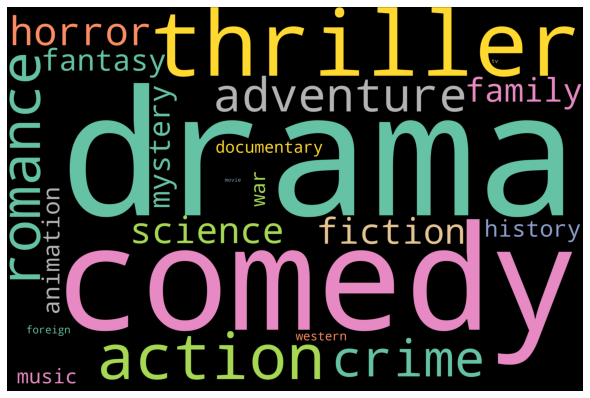

In [ ]:
wordcloud_generator('genres')

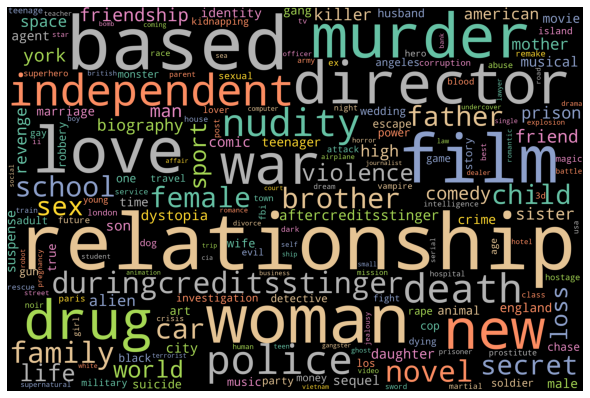

In [ ]:
wordcloud_generator('Keywords')

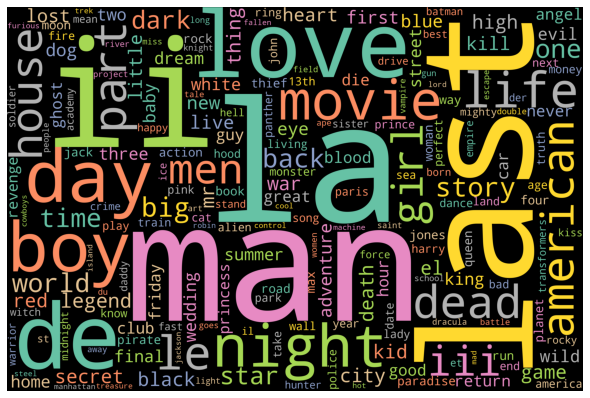

In [ ]:
wordcloud_generator('original_title')

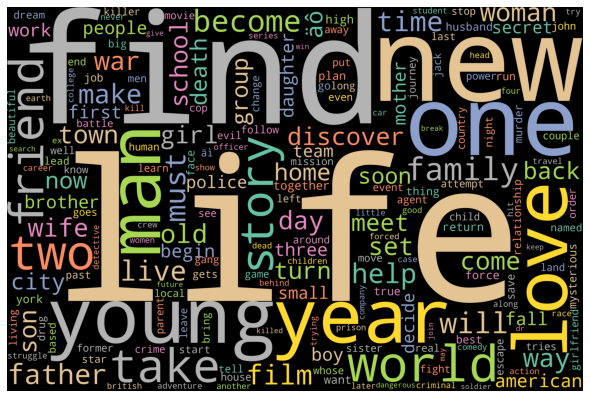

In [ ]:
wordcloud_generator('overview')

Write your answer here

# Part 3 - Time Series Analysis

In [114]:
# TODO: code for time series analysis
df = df_train.copy()
df['Month'] = df['release_date'].apply(lambda date: date.strftime("%B") )
df['Day'] = df['release_date'].apply(lambda date: date.strftime("%A") )
df['Year'] = df['release_date'].apply(lambda date: date.strftime("%Y") )
df.sample(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,Keywords,cast,crew,revenue,Month,Day,Year
2084,2085,1,6000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 27, 'nam...",0,tt0091209,en,The Hitcher,A young man who escaped the clutches of a murd...,5.648114,"[{'name': 'Silver Screen Partners', 'id': 514}...","[{'name': 'United States of America', 'id': 'U...",1986-02-21,97,"[{'name': 'English', 'id': 'en'}]",The terror starts the moment he stops.,The Hitcher,"[{'id': 720, 'name': 'helicopter'}, {'id': 158...","[{'cast_id': 1, 'character': 'Jim Halsey', 'cr...","[{'credit_id': '598da8c8c3a368752400fe79', 'de...",5844868.0,February,Friday,1986
691,692,0,35000000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 14, 'name...",0,tt0304711,en,The Order,"For centuries, a secret Order of priests has e...",5.370818,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'name': 'Germany', 'id': 'DE'}, {'name': 'Un...",2003-09-05,102,"[{'name': 'English', 'id': 'en'}]",Every soul has its price.,The Order,"[{'id': 483, 'name': 'riddle'}, {'id': 588, 'n...","[{'cast_id': 1, 'character': 'Alex Bernier', '...","[{'credit_id': '52fe4512c3a36847f80baaa1', 'de...",11560806.0,September,Friday,2003


In [115]:
#Total Release count by day of week
cats = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

day_release = df.groupby(['Day'],as_index=False).size().reset_index().rename(columns={"size":"Release Count"})
day_release
day_release = day_release[['Day','Release Count']].copy()

day_release = day_release.groupby(['Day']).sum().reindex(cats) 
day_release = day_release.reset_index()
day_release.columns = ['Day', 'Release Count']
day_release.head(100)


,Day,Release Count
0,Monday,124
1,Tuesday,190
2,Wednesday,449
3,Thursday,615
4,Friday,1348
5,Saturday,161
6,Sunday,113


In [116]:
#Total release count by months
month_release = df.groupby('Month', as_index=False).size().reset_index().rename(columns={"size":"Release Count"})
month_release = month_release[['Month', 'Release Count']].copy()
month_release['Month'] =  pd.to_datetime(month_release.Month,format="%B")
month_release = month_release.sort_values(by='Month')
month_release['Month'] = month_release['Month'].apply(lambda date: date.strftime("%B") )
month_release.columns = ['Month', 'Release Count']
month_release

,Month,Release Count
4,January,212
3,February,226
7,March,238
0,April,245
8,May,224
6,June,237
5,July,209
1,August,256
11,September,362
10,October,307


In [117]:
year_release = df.groupby('Year', as_index=False).size().reset_index().rename(columns={"size":"Release Count"})
year_release

,index,Year,Release Count
0,0,1921,1
1,1,1924,1
2,2,1925,2
3,3,1926,1
4,4,1927,2
...,...,...,...
85,85,2013,141
86,86,2014,123
87,87,2015,128
88,88,2016,125


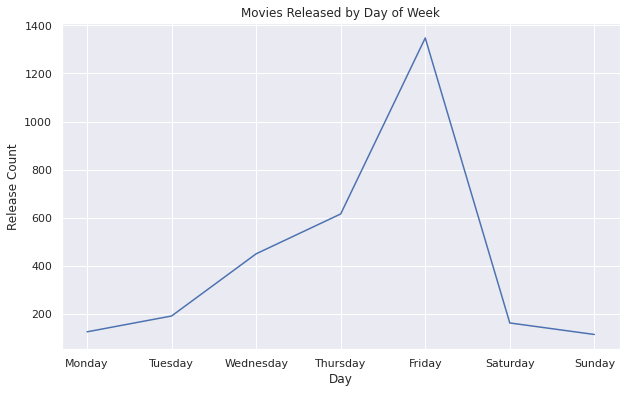

In [118]:
#Plotting the releases count by day of week
plt.figure(figsize=(10,6))
chart = sns.lineplot(x="Day", y="Release Count", data=day_release, sort=False)
chart.set_title('Movies Released by Day of Week')
plt.show()

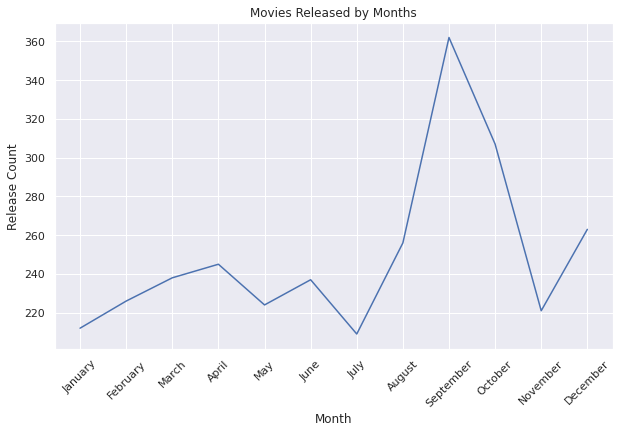

In [119]:
#Plotting the releases count by day of week
months = month_release['Month'].to_list()
plt.figure(figsize=(10,6))
chart = sns.lineplot(x="Month", y="Release Count", data=month_release, sort=False)
chart.set_title('Movies Released by Months')
chart.set_xticklabels(months,rotation=45)
plt.show()

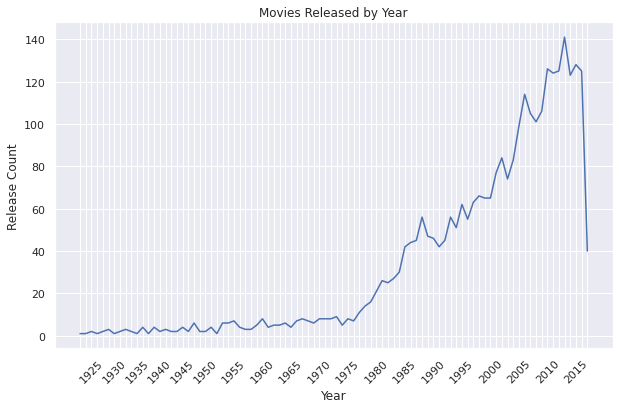

In [120]:
#Plotting the releases count by day of week
years = year_release['Year'].to_list()
plt.figure(figsize=(10,6))
chart = sns.lineplot(x="Year", y="Release Count", data=year_release, sort=False)
chart.set_xticklabels(years,rotation=45)
for label in chart.get_xticklabels():
    if int(label.get_text()) % 5 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)
chart.set_title('Movies Released by Year')
plt.show()

In [121]:
df_train=df.copy()
df_train.sample(2)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     3000 non-null   int64         
 1   belongs_to_collection  3000 non-null   int64         
 2   budget                 3000 non-null   float64       
 3   genres                 3000 non-null   object        
 4   homepage               3000 non-null   int64         
 5   imdb_id                3000 non-null   object        
 6   original_language      3000 non-null   object        
 7   original_title         3000 non-null   object        
 8   overview               2992 non-null   object        
 9   popularity             3000 non-null   float64       
 10  production_companies   3000 non-null   object        
 11  production_countries   3000 non-null   object        
 12  release_date           3000 non-null   datetime64[ns]
 13  run

Write your answer here

# Part 4 - Cast Power

In [122]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_train, test_size=0.2)

In [123]:
#Average RGP for each cast
df_actors['Revenue'] = 0
df_actors['Total'] = 0
def get_total_rev_cast(pd, rev, df):
  global df_actors
  if(len(pd)==0):
    return
  take = 10
  if(len(pd)<10):
    rev = rev/len(pd)
    plus = 1/len(pd)
  else:
    rev = rev/10
    plus = 1/10
  i = 0
  for item in pd:
    if(i==10):
      break
    id = item['id']
    curr = df.loc[df['id']==id].iloc[0]['Revenue']
    curr += rev
    df.loc[df['id']==id, 'Revenue'] = curr

    curr = df.loc[df['id']==id].iloc[0]['Total']
    curr += plus
    df.loc[df['id']==id, 'Total'] = curr
    i+=1

train.apply(lambda x: get_total_rev_cast(x['cast'], x['revenue'], df_actors), axis= 1)
print('actor')
df_actors['Avg_revenue'] = df_actors['Revenue']/df_actors['Total']

actor


In [124]:
df_actors.fillna(0, inplace=True)
id = df_actors.id.to_list()
rev = df_actors.Avg_revenue.to_list()
actor_rgp = {id[i]:rev[i] for i in range(len(id))}



In [125]:
# TODO: code for measuring cast power

actor_freq = {}
gender_freq = {}
def actor_popularity(x):
  global actor_freq
  
  actors = [i['id'] for i in x]
  for actor in actors:
    if(actor not in actor_freq):

      actor_freq[actor]=0
    else:
      actor_freq[actor] += 1
def gender_bias(x):
  genders = [i['gender'] for i in x]
  for gender in genders:
    if(gender not in gender_freq):
      gender_freq[gender] = 0
    else:
      gender_freq[gender] +=1

def cast_power(x, actor_freq):
  actors = [i['id'] for i in x]
  orders = [i['order'] for i in x]
  genders = [i['gender'] for i in x]
  n = len(actors)
  if(n==0):
    return 0
  total = 0
  i = 0
  maxi = max(orders) + 1
  for actor in actors:    
    total += (maxi-orders[i])*(actor_freq[actor]/7398)*gender_freq[genders[i]]*actor_rgp[actor]
    i+=1
  total = total/n
  
  return total

df_train['cast'].apply(actor_popularity)
df_test['cast'].apply(actor_popularity)
df_train['cast'].apply(gender_bias)
df_test['cast'].apply(gender_bias)
total = 0
for k in gender_freq:
  total += gender_freq[k]
for k in gender_freq:
  gender_freq[k] /=total 

print(gender_freq)
train['cast_power'] = train['cast'].apply(lambda x: cast_power(x, actor_freq))
test['cast_power'] = test['cast'].apply(lambda x: cast_power(x, actor_freq))
df_train['cast_power'] =  df_train['cast'].apply(lambda x:cast_power(x, actor_freq))
df_test['cast_power'] = df['cast'].apply(lambda x: cast_power_order(x, actor_freq))

{2: 0.4446319749539405, 1: 0.21895976396923356, 0: 0.336408261076826}


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [126]:
test.corr()

,id,belongs_to_collection,budget,homepage,popularity,revenue,cast_power
id,1.000000,0.030642,-0.022665,-0.035735,-0.034769,-0.039244,-0.030581
belongs_to_collection,0.030642,1.000000,0.232044,0.027928,0.168934,0.341502,0.076368
budget,-0.022665,0.232044,1.000000,0.239614,0.373857,0.787220,0.569506
homepage,-0.035735,0.027928,0.239614,1.000000,0.198823,0.270681,0.229038
popularity,-0.034769,0.168934,0.373857,0.198823,1.000000,0.419871,0.334417
revenue,-0.039244,0.341502,0.787220,0.270681,0.419871,1.000000,0.528740
cast_power,-0.030581,0.076368,0.569506,0.229038,0.334417,0.528740,1.000000


# Part 5 - External Dataset

## Getting External Data

In [127]:
# TODO: code for integrating external dataset
df_mv = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HW3 Data/External Data/IMDb movies.csv', engine='python', error_bad_lines=False)
df_mv = df_mv.rename(columns={'imdb_title_id':'imdb_id'})
df_mv.sample(2)

,imdb_id,title,original_title,year,date_published,genre,duration,country,language,director,writer,production_company,actors,description,avg_vote,votes,budget,usa_gross_income,worlwide_gross_income,metascore,reviews_from_users,reviews_from_critics
10424,tt0054135,Colpo grosso,Ocean's Eleven,1960,1960-12-22,"Comedy, Crime, Music",127,USA,English,Lewis Milestone,"Harry Brown, Charles Lederer",Warner Bros. Pictures,"Frank Sinatra, Dean Martin, Sammy Davis Jr., P...",Danny Ocean gathers a group of his World War I...,6.6,19563,$ 2800000,NaN,NaN,57.0,139.0,59.0
33458,tt0156849,Pro urodov i lyudey,Pro urodov i lyudey,1998,1998,"Comedy, Drama, History",93,Russia,Russian,Aleksey Balabanov,Aleksey Balabanov,CTB Film Company,"Sergey Makovetskiy, Dinara Drukarova, Anzhelik...",Dariya the maid getting a boy to touch her lar...,7.1,3007,NaN,NaN,NaN,NaN,33.0,15.0


In [64]:
#Merging External data with training and test set and saving the ones that are missing
df_ext = pd.merge(df_train, df_mv, on='imdb_id')
got = df_ext.imdb_id.to_list()
df_rest = df_train.loc[df_train['imdb_id'].isin(got)==False]
df_ext_t = pd.merge(df_test, df_mv, on='imdb_id')
got = df_ext_t.imdb_id.to_list()
df_rest_t = df_test.loc[df_test['imdb_id'].isin(got)==False] 

In [65]:
df_rest.to_csv(r'/content/drive/My Drive/Colab Notebooks/HW3 Data/External Data/train_rest.csv', index=False, header=True)
df_rest_t.to_csv(r'/content/drive/My Drive/Colab Notebooks/HW3 Data/External Data/test_rest.csv', index=False, header=True)

In [66]:
# Fetching missing training data with OMDB API
import requests
import json
import time
import datetime
x  = 0
ids = df_rest['imdb_id'].to_list()
titles = df_rest['title'].to_list()
print(len(ids))
api_key = "30f485b0"
base_url = 'http://www.omdbapi.com/?apikey=' + api_key
i = 0
for id in ids:
    final_url = base_url + '&i=' + id
    request = requests.get(final_url)
    data = request.json()
    if(data['Title']=='#DUPE#'):
      final_url = base_url + '&i=' + titles[i]
      request = requests.get(final_url)
      data = request.json()
      data['imdbID'] = id
    if(x == 0):
      dx = pd.DataFrame(data)
      x =1
    else:
      nw = pd.Series(data)
      dd = pd.DataFrame(nw).transpose()
      dx = pd.concat([dx,dd])
    i +=1

dx_ratings = dx['Ratings'].to_list()
dx= dx.drop(['Ratings'], axis=1)
dx = dx.drop_duplicates(keep='first')
dx['Ratings'] = dx_ratings[2:]
dx.sample(2)

145


,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,Error,totalSeasons,Ratings
0,Cropsey,2009,Not Rated,25 Apr 2009,84 min,"Documentary, Crime, Horror, Mystery","Barbara Brancaccio, Joshua Zeman",Joshua Zeman,"Joshua Zeman, Barbara Brancaccio, Bill Ellis, ...",Realizing the urban legend of their youth has ...,English,USA,1 win & 1 nomination.,https://m.media-amazon.com/images/M/MV5BNjMyNT...,73,6.3,"7,566",tt1277936,movie,N/A,N/A,Antidote Films,N/A,True,NaN,NaN,"[{'Source': 'Internet Movie Database', 'Value'..."
0,Halo Legends,2010,PG-13,16 Feb 2010,120 min,"Animation, Action, Adventure, Family, Sci-Fi","Frank O'Connor, Shinji Aramaki, Hideki Futamur...","Joseph Staten (game), Frank O'Connor (screenpl...","Brittney Karbowski, Luci Christian, Josh Grell...",The universe of the Halo video game series is ...,"English, Japanese","USA, Japan",N/A,https://m.media-amazon.com/images/M/MV5BMzE5ND...,N/A,6.6,"5,030",tt1480660,movie,N/A,N/A,N/A,N/A,True,NaN,NaN,"[{'Source': 'Internet Movie Database', 'Value'..."


In [67]:
#Fetching missing test data with OMDB API
x  = 0
ids = df_rest_t['imdb_id'].to_list()
titles = df_rest_t['title'].to_list()
print(len(ids))
i = 0
for id in ids:
    final_url = base_url + '&i=' + id
    request = requests.get(final_url)
    data = request.json()
    if(data['Title']=='#DUPE#'):
      final_url = base_url + '&t=' + titles[i]
      request = requests.get(final_url)
      data = request.json()
      data['imdbID'] = id
    if(x == 0):
      dy = pd.DataFrame(data)
      x =1
    else:
      nw = pd.Series(data)
      dd = pd.DataFrame(nw).transpose()
      dy = pd.concat([dy,dd])
    i +=1

dy_ratings = dy['Ratings'].to_list()
dy= dy.drop(['Ratings'], axis=1)
dy = dy.drop_duplicates(keep='first')
dy['Ratings'] = dy_ratings[2:]
dy.sample(2)

213


,Title,Year,Rated,Released,Runtime,Genre,Director,Writer,Actors,Plot,Language,Country,Awards,Poster,Metascore,imdbRating,imdbVotes,imdbID,Type,DVD,BoxOffice,Production,Website,Response,Error,totalSeasons,Ratings
0,Dr. Horrible's Sing-Along Blog,2008,TV-PG,15 Jul 2008,42 min,"Short, Comedy, Musical, Sci-Fi",N/A,N/A,"Neil Patrick Harris, Nathan Fillion, Felicia D...",An aspiring supervillain must balance his care...,English,USA,Won 1 Primetime Emmy. Another 8 wins & 4 nomin...,https://m.media-amazon.com/images/M/MV5BZTIxZm...,N/A,8.5,"41,255",tt1227926,series,NaN,NaN,NaN,NaN,True,NaN,N/A,"[{'Source': 'Internet Movie Database', 'Value'..."
0,Nunca en horas de clase,1978,N/A,03 Nov 1978,100 min,Comedy,José Antonio de la Loma,José Antonio de la Loma,"Inma de Santis, Nadia Windel, Carlos Ballester...",N/A,Spanish,Spain,N/A,https://m.media-amazon.com/images/M/MV5BZmY0OT...,N/A,4.1,41,tt0078010,movie,N/A,N/A,N/A,N/A,True,NaN,NaN,"[{'Source': 'Internet Movie Database', 'Value'..."


In [128]:
#Adding missing data with external data
df_mv=df_mv[['imdb_id', 'duration', 'avg_vote', 'votes','metascore']]
df_mv = df_mv.rename(columns={'avg_vote':'imdb_rating'})
dx = dx.rename(columns={'imdbID':'imdb_id', 'Runtime':'duration', 'imdbRating':'imdb_rating', 'Metascore':'metascore', 'imdbVotes':'votes'})
dx = dx[['imdb_id', 'duration', 'imdb_rating', 'votes','metascore']]
dy = dy.rename(columns={'imdbID':'imdb_id', 'Runtime':'duration', 'imdbRating':'imdb_rating', 'Metascore':'metascore', 'imdbVotes':'votes'})
dy = dy[['imdb_id', 'duration', 'imdb_rating', 'votes','metascore']]
df_mv = pd.concat([df_mv, dx])
df_mv = pd.concat([df_mv, dy]) 
df_mv


,imdb_id,duration,imdb_rating,votes,metascore
0,tt0000009,45,5.9,154,NaN
1,tt0000574,70,6.1,589,NaN
2,tt0001892,53,5.8,188,NaN
3,tt0002101,100,5.2,446,NaN
4,tt0002130,68,7,2237,NaN
...,...,...,...,...,...
0,tt0117677,96 min,7.7,46,N/A
0,tt0059797,138 min,7.0,"7,440",N/A
0,tt1334510,87 min,7.3,942,78
0,tt1482393,85 min,4.2,"3,344",N/A


In [129]:
#Creating combined data
df_mv['duration'].fillna(0, inplace=True)
df_mv['duration'].replace({'N/A':'0'}, inplace=True)
df_train['runtime'].replace({'N/A':'0'}, inplace=True)
def toint(x):
  x = str(x)
  y = x.split(" ")
  return float(y[0])
df_mv['duration'] = df_mv['duration'].apply(toint)
df_train['runtime'] = df_train['runtime'].apply(toint)
df_test['runtime'] =  df_test['runtime'].apply(toint)



<class 'pandas.core.frame.DataFrame'>
Int64Index: 4398 entries, 0 to 4397
Data columns (total 23 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     4398 non-null   int64         
 1   belongs_to_collection  4398 non-null   int64         
 2   budget                 4398 non-null   float64       
 3   genres                 4398 non-null   object        
 4   homepage               4398 non-null   int64         
 5   imdb_id                4398 non-null   object        
 6   original_language      4398 non-null   object        
 7   original_title         4398 non-null   object        
 8   overview               4384 non-null   object        
 9   popularity             4398 non-null   float64       
 10  production_companies   4398 non-null   object        
 11  production_countries   4398 non-null   object        
 12  release_date           4398 non-null   datetime64[ns]
 13  run

In [414]:
df_ntrain = pd.merge(df_train, df_mv)
df_ntrain.loc[df_ntrain['runtime'].isnull()==True, 'runtime'] = df_ntrain['duration']
df_ntrain = df_ntrain.drop(['duration'], axis=1)
df_ntrain['runtime'] = df_ntrain.runtime.astype(float)
df_ntrain.imdb_rating.fillna(0, inplace=True)
df_ntrain['imdb_rating'] = df_ntrain.imdb_rating.astype(float)
df_ntrain['metascore'].replace({'N/A': '0'}, inplace=True)
df_ntrain['metascore'] = df_ntrain.metascore.astype(float)    
df_ntrain['votes'].fillna(0,inplace=True)
df_ntrain['votes'] = df_ntrain.votes.apply(lambda x: int(str(x).replace(',','')))

df_ntest = pd.merge(df_test, df_mv) 
print(df_ntest)
df_ntest.loc[df_ntest['runtime'].isnull()==True, 'runtime'] = df_ntest['duration']
df_ntest = df_ntest.drop(['duration'], axis=1)
df_ntest.imdb_rating.fillna(0, inplace=True)
df_ntest['imdb_rating'] = df_ntest.imdb_rating.astype(float)
df_ntest['metascore'].replace({'N/A': '0'}, inplace=True)
df_ntest['metascore'] = df_ntest.metascore.astype(float)    
df_ntest['votes'].fillna(0,inplace=True)
df_ntest['votes'] = df_ntest.votes.apply(lambda x: int(str(x).replace(',','')))
df_ntest.fillna(0)

        id  belongs_to_collection      budget  ... imdb_rating   votes metascore
0     3001                      1  15000000.0  ...         6.4    2802       NaN
1     3002                      0     88000.0  ...         5.1    4765       NaN
2     3003                      0  12000000.0  ...         6.1   23169        49
3     3004                      0   6800000.0  ...         8.3  142557        80
4     3005                      0   2000000.0  ...         6.7   6,408        64
...    ...                    ...         ...  ...         ...     ...       ...
4393  7394                      0  42000000.0  ...         6.1   53017        33
4394  7395                      1  19000000.0  ...         5.9   43716        29
4395  7396                      0  16000000.0  ...         7.7   35076        77
4396  7397                      0   2000000.0  ...         6.8  203299        83
4397  7398                      0     64000.0  ...           8   26759       NaN

[4398 rows x 24 columns]


,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,Keywords,cast,crew,imdb_rating,votes,metascore
0,3001,1,15000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 16, '...",1,tt1226251,ja,ディアルガVSパルキアVSダークライ,Ash and friends (this time accompanied by newc...,3.851534,"[{'id': 3035, 'name': '4 Kids Entertainment'}]","[{'name': 'Japan', 'id': 'JP'}, {'name': 'Unit...",2007-07-14,90.0,"[{'name': 'English', 'id': 'en'}, {'name': '日本...",Somewhere Between Time & Space... A Legend Is ...,Pokémon: The Rise of Darkrai,"[{'id': 11451, 'name': 'pok√©mon'}, {'id': 115...","[{'cast_id': 3, 'character': 'Tonio', 'credit_...","[{'credit_id': '52fe44e7c3a368484e03d683', 'de...",6.4,2802,0.0
1,3002,0,88000.0,"[{'id': 27, 'name': 'Horror'}, {'id': 878, 'na...",0,tt0051380,en,Attack of the 50 Foot Woman,When an abused wife grows to giant size becaus...,3.559789,"[{'name': 'Woolner Brothers Pictures Inc.', 'i...","[{'name': 'United States of America', 'id': 'U...",1958-05-19,65.0,"[{'name': 'English', 'id': 'en'}]",A titanic beauty spreads a macabre wave of hor...,Attack of the 50 Foot Woman,"[{'id': 9748, 'name': 'revenge'}, {'id': 9951,...","[{'cast_id': 2, 'character': 'Nancy Fowler Arc...","[{'credit_id': '55807805c3a3685b1300060b', 'de...",5.1,4765,0.0
2,3003,0,12000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",0,tt0118556,en,Addicted to Love,Good-natured astronomer Sam is devastated when...,8.085194,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'name': 'United States of America', 'id': 'U...",1997-05-23,100.0,"[{'name': 'English', 'id': 'en'}]",A Comedy About Lost Loves And Last Laughs,Addicted to Love,"[{'id': 931, 'name': 'jealousy'}, {'id': 9673,...","[{'cast_id': 11, 'character': 'Maggie', 'credi...","[{'credit_id': '52fe4330c3a36847f8041367', 'de...",6.1,23169,49.0
3,3004,0,6800000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10752, 'n...",1,tt1255953,fr,Incendies,A mother's last wishes send twins Jeanne and S...,8.596012,"[{'name': 'TS Productions', 'id': 313}, {'name...","[{'name': 'Canada', 'id': 'CA'}, {'name': 'Fra...",2010-09-04,130.0,"[{'name': 'Français', 'id': 'fr'}, {'name': 'ا...",The search began at the opening of their mothe...,Incendies,"[{'id': 378, 'name': 'prison'}, {'id': 539, 'n...","[{'cast_id': 6, 'character': 'Nawal', 'credit_...","[{'credit_id': '56478092c3a36826140043af', 'de...",8.3,142557,80.0
4,3005,0,2000000.0,"[{'id': 36, 'name': 'History'}, {'id': 99, 'na...",0,tt0418753,en,Inside Deep Throat,"In 1972, a seemingly typical shoestring budget...",3.217680,"[{'id': 23, 'name': 'Imagine Entertainment'}]","[{'name': 'United States of America', 'id': 'U...",2005-02-11,92.0,"[{'name': 'English', 'id': 'en'}]",It was filmed in 6 days for 25 thousand dollar...,Inside Deep Throat,"[{'id': 279, 'name': 'usa'}, {'id': 1228, 'nam...","[{'cast_id': 1, 'character': 'Narrator (voice)...","[{'credit_id': '52fe44ce9251416c75041967', 'de...",6.7,6408,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4393,7394,0,42000000.0,"[{'id': 53, 'name': 'Thriller'}]",0,tt0218922,en,Original Sin,A young man is plunged into a life of subterfu...,9.970359,"[{'name': 'Intermedia Films', 'id': 763}, {'na...","[{'name': 'France', 'id': 'FR'}, {'name': 'Uni...",2001-08-03,118.0,"[{'name': 'English', 'id': 'en'}, {'name': 'De...",This is not a love story - it's a story about ...,Original Sin,"[{'id': 515, 'name': 'women'}, {'id': 572, 'na...","[{'cast_id': 17, 'character': 'Julia Russell/B...","[{'credit_id': '52fe4330c3a36847f80412db', 'de...",6.1,53017,33.0
4394,7395,1,19000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",0,tt0364751,en,Without a Paddle,"Three friends, whose lives have been drifting ...",6.046516,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'name': 'United States of America', 'id': 'U...",2004-0

In [ ]:
df_ntrain.to_csv(r'/content/drive/My Drive/Colab Notebooks/HW3 Data/External Data/train_merged.csv', index=False, header=True)
df_ntest.to_csv(r'/content/drive/My Drive/Colab Notebooks/HW3 Data/External Data/test_merged.csv', index=False, header=True)

In [ ]:
df_ntrain = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HW3 Data/External Data/train_merged.csv')
df_ntest = pd.read_csv('/content/drive/My Drive/Colab Notebooks/HW3 Data/External Data/test_merged.csv')

In [130]:
df_ntrain.sample(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,Keywords,cast,crew,revenue,Month,Day,Year,cast_power,imdb_rating,votes,metascore
1904,1905,0,12530000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10751, '...",0,tt0093148,en,Harry and the Hendersons,"Returning from a hunting trip in the forest, t...",9.296024,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'name': 'United States of America', 'id': 'U...",1987-06-05,110.0,"[{'name': 'English', 'id': 'en'}]","When You Can't Believe Your Eyes, Trust Your H...",Harry and the Hendersons,"[{'id': 1866, 'name': 'bad smell'}, {'id': 259...","[{'cast_id': 7, 'character': 'George Henderson...","[{'credit_id': '52fe44cfc3a36847f80ab433', 'de...",49998613.0,June,Friday,1987,77289.725374,6.0,30666,42.0


##Feature Engineering for *genres*, *original_language* ,*spoken_language*, *production_companies*, *production_countries* and *Keywords* 

In [131]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df_ntrain, test_size=0.3)

In [132]:
df_pd_cmp['Revenue'] = 0
df_genres['Revenue'] = 0
df_pd_cnt['Revenue'] = 0
df_lang['Revenue'] = 0
df_kw['Revenue'] = 0

df_pd_cmp['Total'] = 0
df_genres['Total'] = 0
df_pd_cnt['Total'] = 0
df_lang['Total'] = 0
df_kw['Total'] = 0

def get_total_rev(pd, rev, df):
  if(len(pd)==0):
    return
  rev = rev/len(pd)
  plus = 1/len(pd)
  for item in pd:
    id = item['id']
    curr = df.loc[df['id']==id].iloc[0]['Revenue']
    curr +=rev
    df.loc[df['id']==id, 'Revenue'] = curr

    curr = df.loc[df['id']==id].iloc[0]['Total']
    curr += plus
    df.loc[df['id']==id, 'Total'] = curr

train.apply(lambda x: get_total_rev(x['genres'], x['revenue'], df_genres), axis= 1)
print('g')
train.apply(lambda x: get_total_rev(x['spoken_languages'], x['revenue'], df_lang), axis= 1)
print('l')
train.apply(lambda x: get_total_rev(x['production_companies'], x['revenue'], df_pd_cmp), axis= 1)
print('com')
train.apply(lambda x: get_total_rev(x['production_countries'], x['revenue'], df_pd_cnt), axis= 1)
print('cnt')
train.apply(lambda x: get_total_rev(x['Keywords'], x['revenue'], df_kw), axis= 1)
print('kw')


df_genres['Avg_revenue'] = df_genres['Revenue']/df_genres['Total']
df_lang['Avg_revenue'] = df_lang['Revenue']/df_lang['Total']
df_pd_cmp['Avg_revenue'] = df_pd_cmp['Revenue']/df_pd_cmp['Total']
df_pd_cnt['Avg_revenue'] = df_pd_cnt['Revenue']/df_pd_cnt['Total']
df_kw['Avg_revenue'] = df_kw['Revenue']/df_kw['Total']


g
l
com
cnt
kw


In [133]:
df_genres.fillna(0, inplace=True)
df_pd_cmp.fillna(0, inplace=True)
df_pd_cnt.fillna(0, inplace=True)
df_kw.fillna(0, inplace=True)
df_lang.fillna(0, inplace=True)

In [134]:
id = df_genres.id.to_list()
rev = df_genres.Avg_revenue.to_list()
genres_rgp = {id[i]:rev[i] for i in range(len(id))}

id = df_lang.id.to_list()
rev = df_lang.Avg_revenue.to_list()
lang_rgp = {id[i]:rev[i] for i in range(len(id))}

id = df_pd_cmp.id.to_list()
rev = df_pd_cmp.Avg_revenue.to_list()
pd_cmp_rgp = {id[i]:rev[i] for i in range(len(id))}

id = df_pd_cnt.id.to_list()
rev = df_pd_cnt.Avg_revenue.to_list()
pd_cnt_rgp = {id[i]:rev[i] for i in range(len(id))}

id = df_kw.id.to_list()
rev = df_kw.Avg_revenue.to_list()
kw_rgp = {id[i]:rev[i] for i in range(len(id))}


In [135]:
def get_rgp(x, dic):
  total = 0
  for item in x:
    id = item['id']
    curr = dic[id]
    total +=curr
  return total


train['genre_rgp'] = train['genres'].apply(lambda x: get_rgp(x, genres_rgp))
train['sp_lang_rgp'] = train['spoken_languages'].apply(lambda x: get_rgp(x, lang_rgp))
train['pd_cmp_rgp'] =  train['production_companies'].apply(lambda x: get_rgp(x, pd_cmp_rgp))
train['pd_cnt_rgp'] = train['production_countries'].apply(lambda x: get_rgp(x, pd_cnt_rgp))
train['keywords_rgp'] = train['Keywords'].apply(lambda x: get_rgp(x, kw_rgp))

test['genre_rgp'] = test['genres'].apply(lambda x: get_rgp(x, genres_rgp))
test['sp_lang_rgp'] = test['spoken_languages'].apply(lambda x: get_rgp(x, lang_rgp))
test['pd_cmp_rgp'] = test['production_companies'].apply(lambda x: get_rgp(x, pd_cmp_rgp))
test['pd_cnt_rgp'] = test['production_countries'].apply(lambda x: get_rgp(x, pd_cnt_rgp))
test['keywords_rgp'] = test['Keywords'].apply(lambda x: get_rgp(x, kw_rgp))

df_ntrain['genre_rgp'] = df_ntrain['genres'].apply(lambda x: get_rgp(x, genres_rgp))
df_ntrain['sp_lang_rgp'] = df_ntrain['spoken_languages'].apply(lambda x: get_rgp(x, lang_rgp))
df_ntrain['pd_cmp_rgp'] =  df_ntrain['production_companies'].apply(lambda x: get_rgp(x, pd_cmp_rgp))
df_ntrain['pd_cnt_rgp'] = df_ntrain['production_countries'].apply(lambda x: get_rgp(x, pd_cnt_rgp))
df_ntrain['keywords_rgp'] = df_ntrain['Keywords'].apply(lambda x: get_rgp(x, kw_rgp))



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [262]:
#Average RGP for each cast
df_crew['Revenue'] = 0
df_crew['Total'] = 0
def get_total_rev_crew(pd, rev, df):
  global df_cast
  if(len(pd)==0):
    return

  dir = [i for i in pd if (i['job']=='Director')]
  wri = [i for i in pd if (i['job']=='Writer')]
  if(len(dir)>0):
    dir_rev = (0.6*rev)/len(dir)
  if(len(wri)>0):
    wri_rev = (0.4*rev)/len(wri)
  plus = 1/(len(dir)+len(wri))
  for item in dir:
    id = item['id']
    curr = df.loc[df['id']==id].iloc[0]['Revenue']
    curr += dir_rev
   
    df.loc[df['id']==id, 'Revenue'] = curr

    curr = df.loc[df['id']==id].iloc[0]['Total']
    curr += plus
    df.loc[df['id']==id, 'Total'] = curr
  for item in wri:
    id = item['id']
    curr = df.loc[df['id']==id].iloc[0]['Revenue']
    curr += wri_rev
    df.loc[df['id']==id, 'Revenue'] = curr

    curr = df.loc[df['id']==id].iloc[0]['Total']
    curr += plus
    df.loc[df['id']==id, 'Total'] = curr

train.apply(lambda x: get_total_rev_crew(x['crew'], x['revenue'], df_crew), axis= 1)
print('crew')

df_crew['Avg_revenue'] = df_crew['Revenue']/df_crew['Total']

crew


In [137]:
df_crew.fillna(0, inplace= True)
id = df_crew.id.to_list()
rev = df_crew.Avg_revenue.to_list()
crew_rgp = {id[i]:rev[i] for i in range(len(id))}


In [138]:
# TODO: code for measuring cast power

crew_freq = {}

def crew_popularity(x):
  global crew_freq
  crews = [i['id'] for i in x if ((i['job']=='Director') or (i['job']=='Writer')) ]
  for crew in crews:
    if(crew not in crew_freq):
      crew_freq[crew]=0
    else:
      crew_freq[crew] += 1

def crew_power(x, crew_freq):
  crews = [i['id'] for i in x if (i['job']=='Director') or (i['job']=='Writer')]
  n = len(crews)
  if(n==0):
    return 0
  total = 0
  i = 0
  for crew in crews:    
    rgp = crew_rgp[crew]
    total += (crew_freq[crew])/7398*rgp
    i+=1
  total = total/len(crews)
  
  return total

df_ntrain['crew'].apply(crew_popularity)
df_ntest['crew'].apply(crew_popularity)
train['crew_rgp'] =  train['crew'].apply(lambda x:crew_power(x, crew_freq))
test['crew_rgp'] =  test['crew'].apply(lambda x:crew_power(x, crew_freq))
df_ntrain['crew_rgp'] =  df_train['crew'].apply(lambda x:crew_power(x, crew_freq))
#df_test['cast_power'] = df['cast'].apply(lambda x: cast_power_order(x, actor_freq))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [139]:
train.sample(2)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,Keywords,cast,crew,revenue,Month,Day,Year,cast_power,imdb_rating,votes,metascore,genre_rgp,sp_lang_rgp,pd_cmp_rgp,pd_cnt_rgp,keywords_rgp,crew_rgp
293,294,0,1800000.0,"[{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...",0,tt0119815,pt,"O Que é Isso, Companheiro?","Fernando, a journalist, and his friend César j...",1.791965,"[{'name': 'Miramax Films', 'id': 14}, {'name':...","[{'name': 'Brazil', 'id': 'BR'}]",1997-05-01,110.0,"[{'name': 'English', 'id': 'en'}, {'name': 'Po...",Their goal: freedom. Their only hope: an inter...,Four Days in September,"[{'id': 441, 'name': 'assassination'}, {'id': ...","[{'cast_id': 1, 'character': 'Charles Burke El...","[{'credit_id': '52fe4412c3a368484e00dafd', 'de...",310724.0,May,Thursday,1997,118385.299240,7.4,4469,NaN,2.545674e+08,1.276593e+08,4.050378e+07,2.446555e+06,4.354737e+08,25.200649
78,79,0,1000000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 18, 'name...",0,tt0083064,en,Sharky's Machine,"Sharky gets busted back to working vice, where...",2.633399,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'name': 'United States of America', 'id': 'U...",1981-12-18,122.0,"[{'name': 'English', 'id': 'en'}]","If you mess with a cop like Sharky, you better...",Sharky's Machine,"[{'id': 108, 'name': 'transvestism'}, {'id': 6...","[{'cast_id': 3, 'character': 'Tom Sharky', 'cr...","[{'credit_id': '555507869251411e620004c9', 'de...",35610100.0,December,Friday,1981,191854.048464,6.4,5317,58.0,2.749768e+08,7.396520e+07,1.355450e+08,7.840688e+07,6.033167e+08,2888.085969


In [588]:
df_ntrain.sample(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,Keywords,cast,crew,revenue,Month,Day,Year,cast_power,imdb_rating,votes,metascore,month_revenue_factor,drc_factor,comp_factor
1269,312,0,9500000.0,"[{'id': 18, 'name': 'Drama'}, {'id': 10749, 'n...",1,tt1650048,fr,Laurence Anyways,"Set in the 1980s and 1990s, a man tries to sal...",8.59498,"[{'name': 'MK2 Productions', 'id': 9209}]","[{'name': 'Canada', 'id': 'CA'}, {'name': 'Fra...",2012-05-18,168.0,"[{'name': 'Français', 'id': 'fr'}, {'name': 'E...",NaN,Laurence Anyways,"[{'id': 10180, 'name': 'homosexuality'}, {'id'...","[{'cast_id': 1, 'character': 'Laurence Alia', ...","[{'credit_id': '52fe4accc3a36847f81e22eb', 'de...",12250.0,May,Friday,2012,23.005807,7.7,17796,73.0,0.696269,1.0,0.111111


In [617]:
df_x = df_ntrain.copy()
df_y = df_ntest.copy()
country_pop = {}
top_countries = []

company_pop = {}
top_companies= []

genre_pop = {}
top_genre= []

lang_pop = {}
top_lang= []

kw_pop = {}
top_kw= []


def count_popularity(x, country_pop):

  c = [i['id'] for i in x]
  for id in c:
    if id not in country_pop:
      country_pop[id]=0
    else:
      country_pop[id] +=1


df_train['production_countries'].apply(lambda x: count_popularity(x, country_pop))
df_test['production_countries'].apply(lambda x: count_popularity(x, country_pop))
country_pop = sorted(country_pop.items(), key=lambda x: x[1], reverse=True)
top_countries = [k for (k,v) in country_pop[:10]]
print(top_countries)
df_x['country_popularity'] = df_x['production_countries'].apply(lambda x: sum(i['id'] in top_countries for i in x))
df_y['country_popularity'] = df_y['production_countries'].apply(lambda x: sum(i['id'] in top_countries for i in x))

df_train['production_companies'].apply(lambda x: count_popularity(x, company_pop))
df_test['production_companies'].apply(lambda x: count_popularity(x, company_pop))
company_pop = sorted(company_pop.items(), key=lambda x: x[1], reverse=True)
top_companies = [k for (k,v) in company_pop[:10]]
print(top_companies)
df_x['company_popularity'] = df_x['production_companies'].apply(lambda x: sum(i['id'] in top_companies for i in x))
df_y['company_popularity'] = df_y['production_companies'].apply(lambda x: sum(i['id'] in top_companies for i in x))


df_train['genres'].apply(lambda x: count_popularity(x, genre_pop))
df_test['genres'].apply(lambda x: count_popularity(x, genre_pop))
genre_pop = sorted(genre_pop.items(), key=lambda x: x[1], reverse=True)
top_genres = [k for (k,v) in genre_pop[:10]]
print(genre_pop)
print(top_genres)
df_x['genre_popularity'] = df_x['genres'].apply(lambda x: sum(i['id'] in top_genres for i in x))
df_y['genre_popularity'] = df_y['genres'].apply(lambda x: sum(i['id'] in top_genres for i in x))


df_train['spoken_languages'].apply(lambda x: count_popularity(x, lang_pop))
df_test['spoken_languages'].apply(lambda x: count_popularity(x, lang_pop))
lang_pop = sorted(lang_pop.items(), key=lambda x: x[1], reverse=True)
top_lang = [k for (k,v) in lang_pop[:10]]
print(lang_pop)
print(top_lang)
df_x['lang_popularity'] = df_x['spoken_languages'].apply(lambda x: sum(i['id'] in top_lang for i in x))
df_y['lang_popularity'] = df_y['spoken_languages'].apply(lambda x: sum(i['id'] in top_lang for i in x))

df_train['Keywords'].apply(lambda x: count_popularity(x, kw_pop))
df_test['Keywords'].apply(lambda x: count_popularity(x, kw_pop))
kw_pop = sorted(kw_pop.items(), key=lambda x: x[1], reverse=True)
top_kw = [k for (k,v) in kw_pop[:10]]
print(kw_pop)
print(top_kw)
df_x['kw_popularity'] = df_x['Keywords'].apply(lambda x: sum(i['id'] in top_kw for i in x))
df_y['kw_popularity'] = df_y['Keywords'].apply(lambda x: sum(i['id'] in top_kw for i in x))


df_ntrain = df_x.copy()
df_ntest = df_y.copy()

['US', 'GB', 'FR', 'DE', 'CA', 'IN', 'IT', 'JP', 'AU', 'ES']
[6194, 33, 4, 306, 5, 8411, 12, 9195, 2, 441]
[(18, 3688), (35, 2611), (53, 1871), (28, 1739), (10749, 1438), (12, 1117), (80, 1088), (878, 743), (27, 734), (10751, 675), (14, 628), (9648, 551), (16, 381), (36, 294), (10402, 266), (10752, 243), (99, 222), (37, 116), (10769, 83), (10771, 1), (10770, 0), (10772, 0)]
[18, 35, 53, 28, 10749, 12, 80, 878, 27, 10751]
[('en', 6499), ('fr', 710), ('es', 558), ('de', 418), ('ru', 363), ('it', 320), ('ja', 203), ('zh', 162), ('hi', 159), ('ar', 101), ('pt', 99), ('cn', 88), ('ko', 77), ('pl', 68), ('la', 65), ('hu', 63), ('cs', 56), ('th', 54), ('ta', 51), ('sv', 49), ('he', 40), ('tr', 35), ('el', 31), ('da', 26), ('nl', 22), ('ur', 22), ('ro', 22), ('vi', 22), ('no', 19), ('yi', 18), ('te', 16), ('uk', 16), ('ml', 16), ('fa', 14), ('fi', 14), ('xx', 11), ('sr', 10), ('gd', 8), ('af', 8), ('is', 8), ('tl', 7), ('bn', 7), ('sw', 7), ('ga', 6), ('ca', 6), ('bg', 6), ('sq', 5), ('pa', 4)

## Feature Engineering for *release_time*

### month_revenue_factor

In [415]:
month_revenue = train.groupby('Month', as_index=False).agg({'revenue': 'mean'})
maxi = month_revenue['revenue'].max()
month_revenue['month_revenue_factor'] = month_revenue['revenue']/maxi
month_revenue = month_revenue.rename(columns={'revenue': 'm_revenue'})
df_ntrain = pd.merge(df_ntrain, month_revenue)
df_ntrain = df_ntrain.drop(['m_revenue'], axis=1)
df_ntrain.sample(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,Keywords,cast,crew,revenue,Month,Day,Year,cast_power,imdb_rating,votes,metascore,month_revenue_factor
766,2824,0,6900000.0,"[{'id': 18, 'name': 'Drama'}]",1,tt1366409,en,Miral,A drama centered on an orphaned Palestinian gi...,4.435032,"[{'name': 'Eran Riklis Productions Ltd.', 'id'...","[{'name': 'France', 'id': 'FR'}, {'name': 'Isr...",2010-10-01,112.0,"[{'name': 'English', 'id': 'en'}]",Is this the face of a terrorist?,Miral,[],"[{'cast_id': 3, 'character': 'Miral', 'credit_...","[{'credit_id': '52fe46cac3a36847f8112555', 'de...",852336.0,October,Friday,2010,139811.869327,6.2,3194,45.0,0.316559


### drc_factor

In [416]:
maxi = day_release['Release Count'].max()
day_release['drc_factor'] = day_release['Release Count']/maxi
df_ntrain = pd.merge(df_ntrain, day_release)
df_ntrain = df_ntrain.drop(['Release Count'], axis=1)
df_ntrain.sample(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,Keywords,cast,crew,revenue,Month,Day,Year,cast_power,imdb_rating,votes,metascore,month_revenue_factor,drc_factor
1889,1436,0,22500000.0,"[{'id': 10752, 'name': 'War'}, {'id': 18, 'nam...",1,tt3007512,en,The Water Diviner,"In 1919, Australian farmer Joshua Connor trave...",9.615664,"[{'name': 'Hopscotch Features', 'id': 21079}, ...","[{'name': 'Australia', 'id': 'AU'}, {'name': '...",2014-12-25,112.0,"[{'name': 'Pусский', 'id': 'ru'}, {'name': 'Tü...",To honour a promise. To find his sons. To make...,The Water Diviner,"[{'id': 1847, 'name': 'istanbul'}, {'id': 5657...","[{'cast_id': 1, 'character': 'Joshua Connor', ...","[{'credit_id': '530b1a37c3a36842010056a5', 'de...",15520023.0,December,Thursday,2014,523288.192017,7.0,70359,50.0,0.761486,0.456231


### competition_factor

In [417]:
df = df_ntrain.copy()
def count_comp(x):
  be = x - datetime.timedelta(days=13)
  af = x + datetime.timedelta(days=13)
  n = len(df.loc[(df['release_date']>=be) & (df['release_date']<=af)])-1
  return n
  
df['comp_movies'] = df['release_date'].apply(count_comp)
df['comp_factor'] = 1/ df['comp_movies']
df_ntrain['comp_factor'] = df['comp_factor']
df_ntrain.sample(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,Keywords,cast,crew,revenue,Month,Day,Year,cast_power,imdb_rating,votes,metascore,month_revenue_factor,drc_factor,comp_factor
1502,2870,0,13000000.0,"[{'id': 35, 'name': 'Comedy'}]",1,tt2170593,en,St. Vincent,A young boy whose parents just divorced finds ...,13.655752,"[{'name': 'The Weinstein Company', 'id': 308},...","[{'name': 'United States of America', 'id': 'U...",2014-10-09,102.0,"[{'name': 'English', 'id': 'en'}]",Love Thy Neighbor,St. Vincent,"[{'id': 2604, 'name': 'babysitter'}, {'id': 60...","[{'cast_id': 3, 'character': 'Vincent', 'credi...","[{'credit_id': '546eafd8c3a3682f9e000ae0', 'de...",54837234.0,October,Thursday,2014,527114.603703,7.2,94385,64.0,0.316559,0.456231,0.058824


In [418]:
df_ntrain.corr()

,id,belongs_to_collection,budget,homepage,popularity,runtime,revenue,cast_power,imdb_rating,votes,metascore,month_revenue_factor,drc_factor,comp_factor
id,1.000000,-0.010010,0.016743,-0.006177,-0.007470,0.009138,0.000480,0.016776,-0.005840,-0.023480,-0.032564,0.026155,0.006265,0.026023
belongs_to_collection,-0.010010,1.000000,0.211827,0.060001,0.155896,-0.036117,0.339439,0.166760,-0.080439,0.214592,-0.107634,0.089028,-0.059950,0.063926
budget,0.016743,0.211827,1.000000,0.231233,0.327371,0.217618,0.740305,0.649803,-0.004826,0.443274,-0.047302,0.182623,-0.110758,-0.078091
homepage,-0.006177,0.060001,0.231233,1.000000,0.164797,0.041772,0.263148,0.241320,0.073442,0.265605,0.054119,0.010204,-0.112423,-0.226372
popularity,-0.007470,0.155896,0.327371,0.164797,1.000000,0.134027,0.461458,0.344771,0.154367,0.443858,0.114483,0.069095,-0.071553,-0.028748
runtime,0.009138,-0.036117,0.217618,0.041772,0.134027,1.000000,0.216084,0.217833,0.338349,0.246893,0.266471,0.109570,-0.052511,0.014568
revenue,0.000480,0.339439,0.740305,0.263148,0.461458,0.216084,1.000000,0.706355,0.144294,0.629621,0.092236,0.206557,-0.125445,-0.030985
cast_power,0.016776,0.166760,0.649803,0.241320,0.344771,0.217833,0.706355,1.000000,0.107821,0.543646,0.056057,0.125910,-0.058524,-0.065006
imdb_rating,-0.005840,-0.080439,-0.004826,0.073442,0.154367,0.338349,0.144294,0.107821,1.000000,0.371799,0.678924,0.059776,-0.128152,0.032557
votes,-0.023480,0.214592,0.443274,0.265605,0.443858,0.246893,0.629621,0.543646,0.371799,1.000000,0.269105,0.113516,-0.094442,-0.031076


# Part 6 - Informative Plots

## Behaviour of IMDB Rating Over the Years

In [144]:
# TODO: code for producing informative plots

avg_votes = df_ntrain.groupby('Year', as_index=False).agg({'imdb_rating':'mean'})
avg_votes['Legend'] = 'Average Rating'
max_votes = df_ntrain.groupby('Year', as_index=False).agg({'imdb_rating':'max'})
max_votes['Legend'] = 'Maximum Rating'
min_votes = df_ntrain.groupby('Year', as_index=False).agg({'imdb_rating':'min'})
min_votes['Legend'] = 'Minimum Rating'

avg_votes = pd.concat([avg_votes, max_votes])
avg_votes = pd.concat([avg_votes, min_votes])

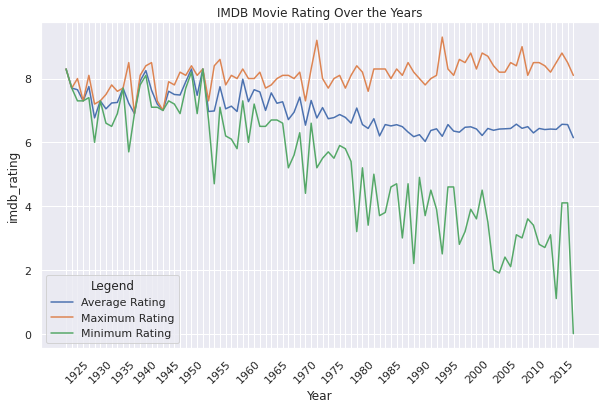

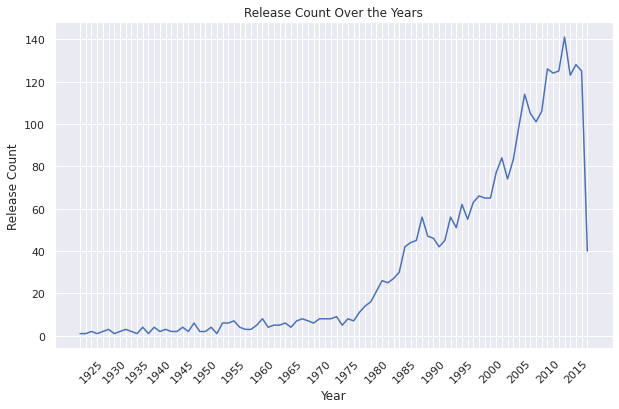

In [ ]:
#Plotting the releases count by day of week
years = avg_votes['Year'].to_list()
plt.figure(figsize=(10,6))
chart = sns.lineplot(x="Year", y="imdb_rating", hue="Legend", data=avg_votes, sort=False)
chart.set_xticklabels(years,rotation=45)
for label in chart.get_xticklabels():
    if int(label.get_text()) % 5 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)
chart.set_title('IMDB Movie Rating Over the Years')
plt.show()

plt.figure(figsize=(10,6))
chart = sns.lineplot(x="Year", y="Release Count", data=year_release, sort=False)
chart.set_xticklabels(years,rotation=45)
for label in chart.get_xticklabels():
    if int(label.get_text()) % 5 == 0:  
        label.set_visible(True)
    else:
        label.set_visible(False)
chart.set_title('Release Count Over the Years')
plt.show()



### Top-20 Production Companies with Highest Revenue

In [ ]:
df_pd_cmp

,name,id,Revenue,Total,Avg_revenue
0,Paramount Pictures,4,6.601130e+09,63.467460,1.040081e+08
1,United Artists,60,1.103656e+09,13.616667,8.105183e+07
2,Metro-Goldwyn-Mayer (MGM),8411,1.701090e+09,32.461905,5.240265e+07
3,Walt Disney Pictures,2,5.284717e+09,19.492857,2.711104e+08
4,Bold Films,2266,8.094294e+07,1.500000,5.396196e+07
...,...,...,...,...,...
7328,MGM/UA Television,96233,0.000000e+00,0.000000,0.000000e+00
7329,M6 Films Production,96234,0.000000e+00,0.000000,0.000000e+00
7330,Le Studio Canal +,96235,0.000000e+00,0.000000,0.000000e+00
7331,Centre National de la Cinematographie,96236,0.000000e+00,0.000000,0.000000e+00


In [ ]:
df_pd_cmp = df_pd_cmp.sort_values(by='Revenue', ascending=False)
df_pd_cmp

,name,id,Revenue,Total,Avg_revenue
0,Paramount Pictures,4,6.601130e+09,63.467460,1.040081e+08
3,Walt Disney Pictures,2,5.284717e+09,19.492857,2.711104e+08
111,Warner Bros.,6194,5.231299e+09,62.202381,8.410127e+07
56,Universal Pictures,33,4.821821e+09,63.292893,7.618266e+07
12,Twentieth Century Fox Film Corporation,306,4.143846e+09,36.865115,1.124056e+08
...,...,...,...,...,...
4387,JC Group International,79731,0.000000e+00,0.000000,0.000000e+00
4388,Talent International Media,79732,0.000000e+00,0.000000,0.000000e+00
4389,Talent International Film Cultural Company,79733,0.000000e+00,0.000000,0.000000e+00
4390,Decia Films,37048,0.000000e+00,0.000000,0.000000e+00


In [ ]:
df_ntrain.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'runtime', 'spoken_languages', 'status', 'tagline',
       'title', 'Keywords', 'cast', 'crew', 'revenue', 'imdb_rating', 'votes',
       'metascore'],
      dtype='object')

In [ ]:
!pip install millify

  Created wheel for millify: filename=millify-0.1.1-cp36-none-any.whl size=1867 sha256=9b8ab964f329e5d017801ef82300490df2d985fcc0186d1241257e3e33013acb
  Stored in directory: /root/.cache/pip/wheels/19/7d/d9/3f1ca52c5b6c4f05b11f1ab5a088fc1cf6174965e81308faeb
Successfully built millify


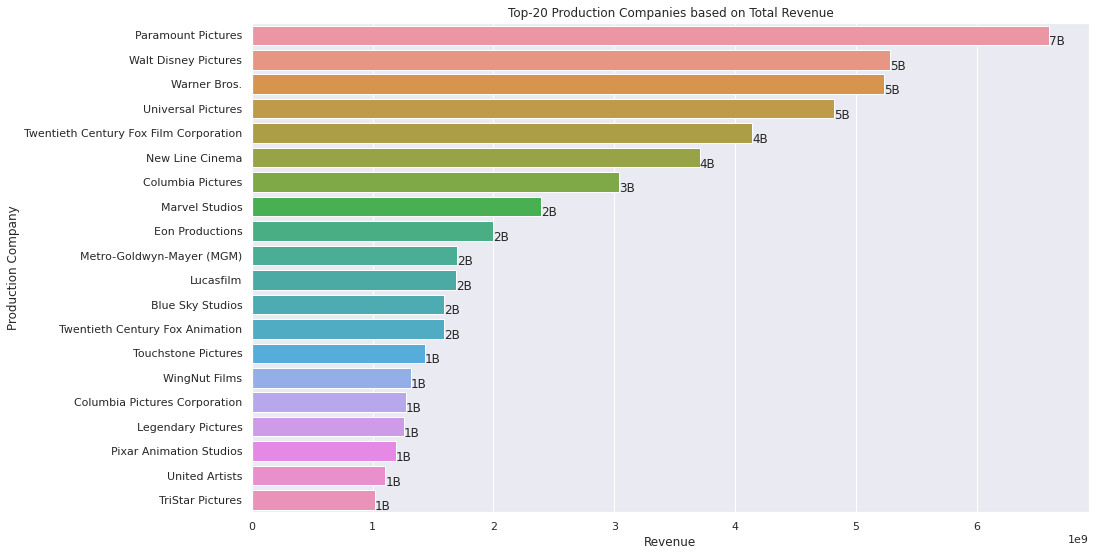

In [ ]:
from millify import millify
years = df_pd_cmp['name'].to_list()
plt.figure(figsize=(15,9))
chart = sns.barplot(x="Revenue", y="name", data=df_pd_cmp[:20],)
chart.set_title('Top-20 Production Companies based on Total Revenue')
chart.set_ylabel("Production Company")

for p in chart.patches:
  x_ = p.get_x() + p.get_width() 
  y_ = p.get_y() + p.get_height()
  value = millify(int(p.get_width()))
  chart.text(x_, y_, value, ha="left")

plt.show()


### Movies with Big-Name Actors tend to Have More votes and Better IMDB Ratings

In [ ]:
def get_rel_freq(words):
  stopwords = set(STOPWORDS)
  words = re.sub(r'==.*?==+', '', words)
  words = words.replace('\n','')
  wordcloud = WordCloud(width = 3000, height = 2000, random_state=1, background_color='black', colormap='Set2', collocations=False).generate(words) 
  return wordcloud.words_

genres = ""
def extract_names(x):
  global genres
  y = [a['name'] for a in x]
  py = []
  for g in y:
    g = g.replace(" ", "")
    py.append(g)
  genres += " ".join(name for name in py)+" "

df = df_ntrain.copy()
df = df[['genres', 'metascore']]
df['genres'].apply(lambda x: extract_names(x))
df_genres['name_mod'] = df_genres.name.apply(lambda x: x.replace(" ", ""))
freq = get_rel_freq(genres)
print(freq)
df_genres['freq'] = df_genres['name_mod'].apply(lambda x: freq[x] if x in freq else 0)



{'Drama': 1.0, 'Comedy': 0.6710097719869706, 'Thriller': 0.5146579804560261, 'Action': 0.48338762214983716, 'Romance': 0.3732899022801303, 'Crime': 0.3055374592833876, 'Adventure': 0.28664495114006516, 'Horror': 0.19609120521172638, 'ScienceFiction': 0.18892508143322476, 'Family': 0.16938110749185667, 'Fantasy': 0.1517915309446254, 'Mystery': 0.1472312703583062, 'Animation': 0.09185667752442997, 'History': 0.08599348534201955, 'Music': 0.06514657980456026, 'War': 0.06514657980456026, 'Documentary': 0.05667752442996743, 'Western': 0.028013029315960912, 'Foreign': 0.020195439739413682, 'TVMovie': 0.0006514657980456026}


In [ ]:
emp = []
pop = []
ms = []
def get_avg_ms(pd, rev):
  if len(pd)==0:
    return
  for item in pd:
    id = item['id']
    p = df_genres.loc[df_genres['id']==id].iloc[0]['freq']
    pop.append(p)
    ms.append(rev)

df_ntrain.loc[(df_ntrain['metascore']!=0) & (df_ntrain['metascore'].isnull()==False)].apply(lambda x: get_avg_ms(x['genres'], x['metascore']), axis= 1)

print(pop)
print(ms)

[0.6710097719869706, 0.6710097719869706, 1.0, 0.16938110749185667, 0.3732899022801303, 1.0, 0.19609120521172638, 0.5146579804560261, 0.05667752442996743, 0.48338762214983716, 0.6710097719869706, 0.06514657980456026, 0.16938110749185667, 0.28664495114006516, 0.6710097719869706, 0.06514657980456026, 1.0, 0.6710097719869706, 1.0, 0.6710097719869706, 0.3055374592833876, 0.48338762214983716, 0.5146579804560261, 0.18892508143322476, 0.1472312703583062, 0.19609120521172638, 0.5146579804560261, 1.0, 0.3732899022801303, 0.6710097719869706, 0.3732899022801303, 0.48338762214983716, 0.5146579804560261, 0.3055374592833876, 0.28664495114006516, 0.16938110749185667, 0.18892508143322476, 0.19609120521172638, 0.5146579804560261, 0.5146579804560261, 0.19609120521172638, 0.19609120521172638, 0.6710097719869706, 0.3055374592833876, 1.0, 0.1472312703583062, 0.5146579804560261, 1.0, 0.6710097719869706, 0.3732899022801303, 0.48338762214983716, 0.28664495114006516, 0.3055374592833876, 0.5146579804560261, 1.0,

In [ ]:
import math
df_select = df_ntrain[(df_ntrain['imdb_rating']>0) & (df_ntrain['cast_rgp']>0)]
df_select['log_rgp'] = df_select['cast_rgp'].apply(lambda x: math.log(x))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


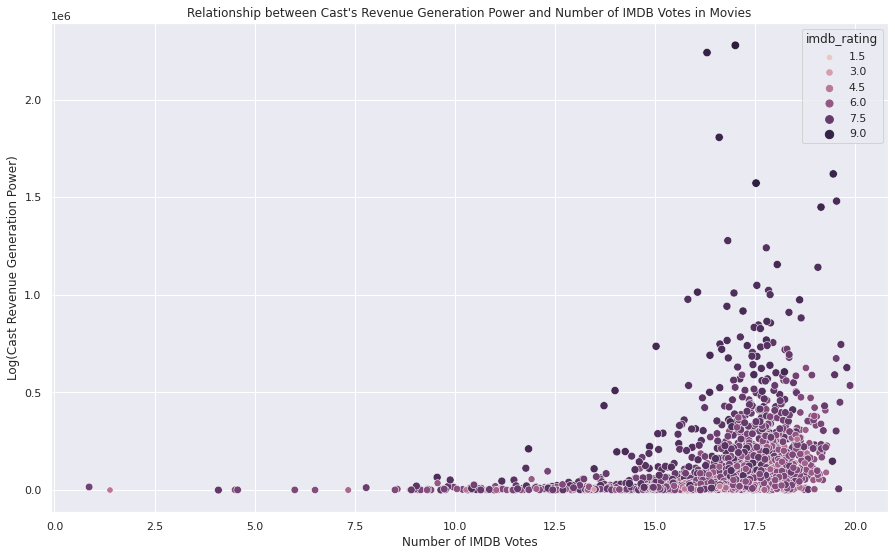

In [ ]:
plt.figure(figsize=(15,9))
chart = sns.scatterplot( data = df_select, x='log_rgp', y='votes', hue='imdb_rating', size='imdb_rating')
chart.set_title('Relationship between Cast\'s Revenue Generation Power and Number of IMDB Votes in Movies')
chart.set_xlabel('Number of IMDB Votes')
chart.set_ylabel("Log(Cast Revenue Generation Power)")

plt.show()

## IMDB Metascore Distribution

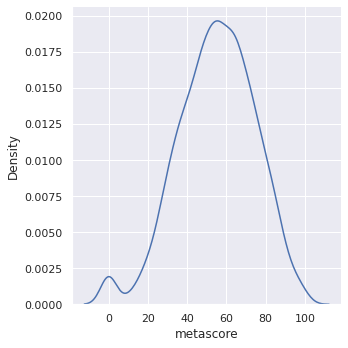

In [ ]:
sns.displot(df_ntrain ,x="metascore", kind="kde")


In [ ]:
def extract_male(x):
  y = [a['gender'] for a in x]
  ids = [a['id'] for a in x]
  count = 0
  take = 10
  j = 0
  for i in y:
    if(take==0):
      break
    take -=1
    if(i==2):
      rgp = actor_rgp[ids[j]]
      count +=rgp
    j +=1
  return count
def extract_female(x):
  y = [a['gender'] for a in x]
  ids = [a['id'] for a in x]
  take = 10
  count=0
  j=0 
  for i in y:
    if(take==0):
      break
    take -=1
    if(i==1):
      rgp = actor_rgp[ids[j]]
      count += rgp
    j +=1
  return count
df = df_ntrain.copy()
df = df.sort_values(by='revenue', ascending=False)
big_movies = df.groupby('Year', as_index=False).agg({'title': 'first','cast': 'first', 'revenue':'first'})
big_movies['Male_RGP'] = big_movies['cast'].apply(lambda x: extract_male(x)) 
big_movies['Female_RGP'] = big_movies['cast'].apply(lambda x: extract_female(x)) 
big_movies['Male_Ratio'] = big_movies.apply(lambda x: (x['Male_RGP']/(x['Male_RGP']+x['Female_RGP']+1))*x['revenue'], axis=1)
big_movies['Female_Ratio'] = big_movies['revenue']-big_movies['Male_Ratio'] 
big_movies = big_movies[big_movies['Year']>"1970"]

Text(0.5, 1.0, 'Contribution Ratio of Male and Female Cast members to the Movie Revenue of the Biggest Movie According to Their RGP (10s)')

<Figure size 1080x648 with 0 Axes>

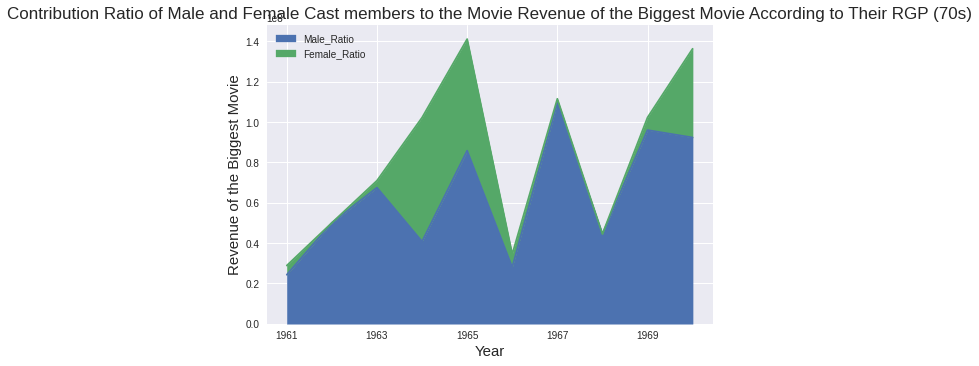

<Figure size 1080x648 with 0 Axes>

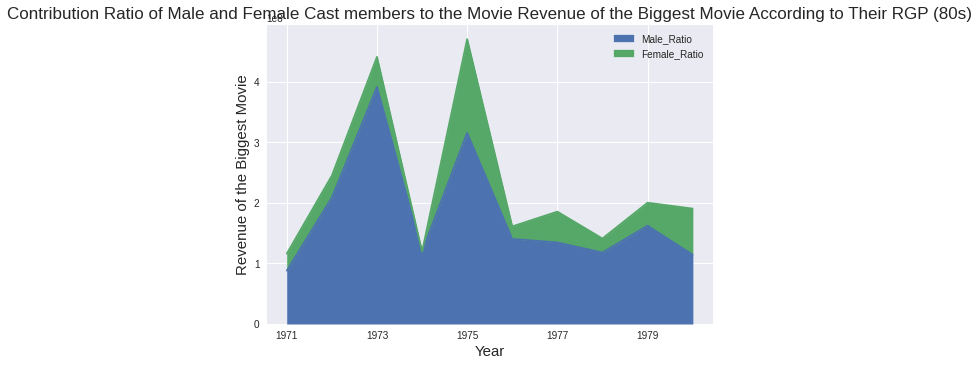

<Figure size 1080x648 with 0 Axes>

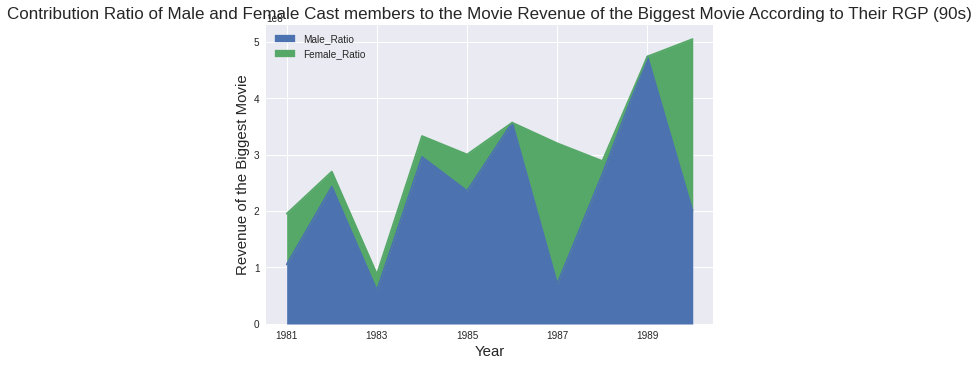

<Figure size 1080x648 with 0 Axes>

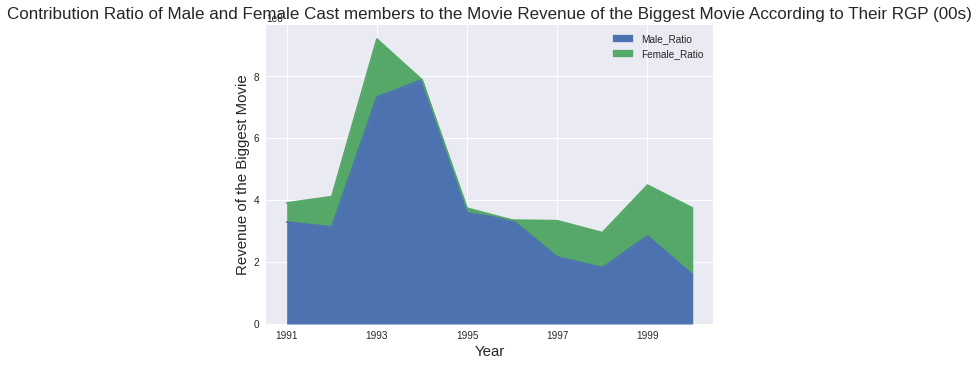

<Figure size 1080x648 with 0 Axes>

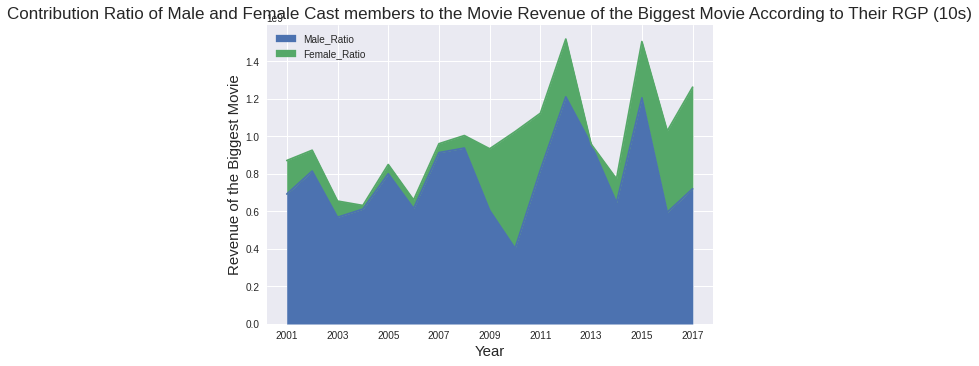

In [ ]:
plt.figure(figsize=(15,9))
plt.style.use('seaborn')
big_movies[:10].plot.area(x='Year', y=['Male_Ratio', 'Female_Ratio'], stacked=True)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Revenue of the Biggest Movie', fontsize=15)
plt.title('Contribution Ratio of Male and Female Cast members to the Movie Revenue of the Biggest Movie According to Their RGP (70s)',fontsize=17)

plt.figure(figsize=(15,9))
plt.style.use('seaborn')
big_movies[10:20].plot.area(x='Year', y=['Male_Ratio', 'Female_Ratio'], stacked=True)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Revenue of the Biggest Movie', fontsize=15)
plt.title('Contribution Ratio of Male and Female Cast members to the Movie Revenue of the Biggest Movie According to Their RGP (80s)',fontsize=17)

plt.figure(figsize=(15,9))
plt.style.use('seaborn')
big_movies[20:30].plot.area(x='Year', y=['Male_Ratio', 'Female_Ratio'], stacked=True)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Revenue of the Biggest Movie', fontsize=15)
plt.title('Contribution Ratio of Male and Female Cast members to the Movie Revenue of the Biggest Movie According to Their RGP (90s)',fontsize=17)


plt.figure(figsize=(15,9))
plt.style.use('seaborn')
big_movies[30:40].plot.area(x='Year', y=['Male_Ratio', 'Female_Ratio'], stacked=True)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Revenue of the Biggest Movie', fontsize=15)
plt.title('Contribution Ratio of Male and Female Cast members to the Movie Revenue of the Biggest Movie According to Their RGP (00s)',fontsize=17)


plt.figure(figsize=(15,9))
plt.style.use('seaborn')
big_movies[40:].plot.area(x='Year', y=['Male_Ratio', 'Female_Ratio'], stacked=True)
plt.xlabel('Year', fontsize=15)
plt.ylabel('Revenue of the Biggest Movie', fontsize=15)
plt.title('Contribution Ratio of Male and Female Cast members to the Movie Revenue of the Biggest Movie According to Their RGP (10s)',fontsize=17)



Write your answer here

# Part 7 - Pairwise Pearson Correlation

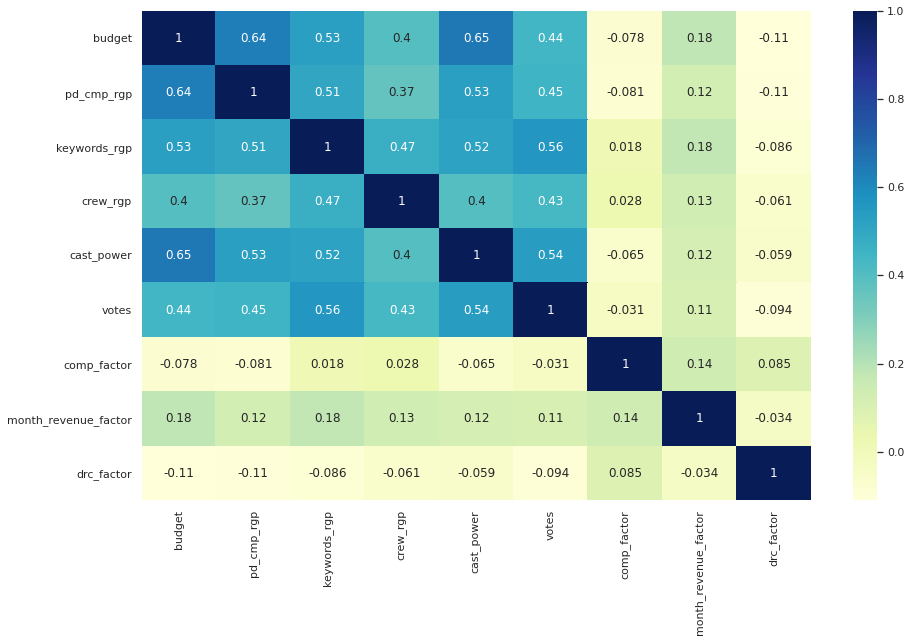

In [146]:
# TODO: code for pairwise Pearson correlation
df_pearson = df_ntrain[['budget', 'pd_cmp_rgp', 'keywords_rgp', 'crew_rgp', 'cast_power', 'votes', 'comp_factor', 'month_revenue_factor', 'drc_factor' ]]
plt.figure(figsize=(15,9))
chart = sns.heatmap(df_pearson.corr(), annot=True, cmap="YlGnBu")
plt.show()

Write your answer here

# Part 8 - Regression and Permutation Test

In [ ]:
# TODO: code for your regression models and permutation tests

In [160]:
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn import datasets, linear_model, metrics 
from sklearn.model_selection import permutation_test_score
def split_data(df):
  from sklearn.model_selection import train_test_split 
  train, test = train_test_split(df, test_size=0.3, random_state=1) 
  return train, test

def rmsle(y_true, y_pred):
  #y_true = np.log(y_true)
  y_pred = y_pred.tolist()
  #for i in range(len(y_pred)):
    #if(y_pred[i]<0):
     # y_pred[i]=0.00000001
  #y_pred = np.array(y_pred)
  #y_pred = np.log(y_pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
  return rmse

def permutation_test(train,test, feature):
  X_train = train[[feature]]
  y_train = train.revenue  
  X_test = test[[feature]]
  y_test = test.revenue
  n_permutations = 100


  reg = linear_model.LinearRegression() 
  y_train = y_train.to_numpy()
  model = reg.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  score = rmsle(y_test, y_pred)

  permutation_scores = []
  rank = 0
  for i in range(n_permutations):
    y_curr = np.random.permutation(y_train)
    model_curr = reg.fit(X_train, y_curr)
    y_pred_curr = model_curr.predict(X_train)
    score_curr = rmsle(y_curr, y_pred_curr)
    permutation_scores.append(score_curr)
    if(score>score_curr):
      rank += 1
  pvalue = (rank+1)/(n_permutations+1)
  print(score, pvalue, permutation_scores)
  plt.hist(permutation_scores, 20, label='Permutation scores',
         edgecolor='black')
  ylim = plt.ylim()
  plt.plot(2 * [score], ylim, '--g', linewidth=3,
         label='Model Score'
         ' (pvalue %s)' % pvalue)

  plt.ylim(ylim)
  plt.legend()
  plt.xlabel('Score')
  plt.show()
  return model

def test_model(test, feature, model):
  X_test = test[[feature]]
  y_test = test.revenue.apply(lambda x: np.log(x))
  y_pred = model.predict(X_test)
  y_pred = y_pred.tolist()
  for i in range(len(y_pred)):
    if(y_pred[i]<0):
      y_pred[i]=0.00000001
  y_pred = np.array(y_pred)
  y_pred = np.log(y_pred)
  rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
  print(rmse)

129458403.27138254 0.009900990099009901 [139174756.94330397, 138947330.7364858, 139182527.67421988, 139168319.4453448, 139160522.8887157, 139155171.2240388, 139172612.547797, 139161988.59474698, 139174691.30530125, 139176286.64274842, 139185011.22172222, 139155638.40416414, 139146631.1126844, 139177791.39586762, 139186804.3598589, 139182509.16633633, 139182452.25974497, 139168657.55424443, 139179063.47195843, 139190952.18244165, 139096213.34350735, 139179990.19107324, 139184866.86538067, 139189100.0464539, 139174095.66611594, 139184499.34509853, 139191585.55577555, 139189046.12348124, 139185547.35235092, 139181471.2619085, 139181986.69435114, 138930187.79574186, 139173002.75080925, 139152761.60429493, 139172025.2830216, 139177369.90447864, 139191241.0774297, 139130064.61764526, 139164345.09324813, 139176822.6220393, 139181432.46015272, 139191619.52533305, 139177842.02754158, 139190571.09297845, 139177960.72247443, 139175297.56801206, 139187766.04135385, 139122019.10309097, 139172405.07

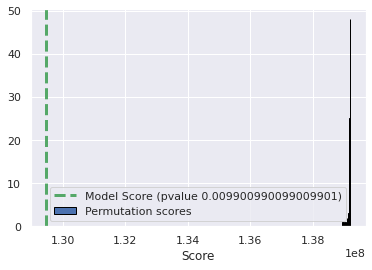

111356681.0474887 0.009900990099009901 [139159654.80871215, 139181813.99615443, 139173286.98324317, 139183188.87786672, 139163126.5807373, 139167145.2352181, 139170300.3788329, 139155721.90358928, 139139453.75107017, 139187993.0252832, 139191244.3882668, 139111286.23602527, 139163830.8743204, 139161917.37023214, 139165399.449675, 139191478.36014357, 139187899.55114284, 139181104.0199817, 139063740.18668994, 139031283.06743106, 139145995.8804868, 139188211.9495377, 139178054.8851116, 139135235.2917317, 139191277.39761817, 139190941.42874405, 139011962.32098788, 139178352.5963613, 139142528.54005533, 139188432.56013724, 139191030.54405916, 139155056.24846396, 139186833.0021131, 139191619.29637647, 139160014.6683631, 139151004.55844656, 139146443.75050905, 139139350.4471128, 139191434.61249828, 139166157.2668201, 138846019.8735908, 138901293.4186211, 139006350.36438859, 139173933.43343174, 139183736.0562609, 139171200.33788878, 139183336.16340032, 139151939.04421973, 139184742.7158287, 13

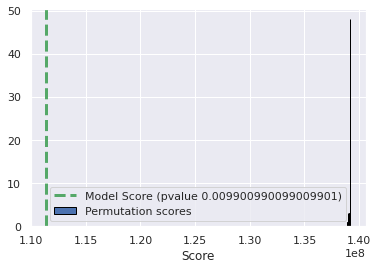

98662639.7821724 0.009900990099009901 [139187137.70300284, 139190696.06799448, 139178241.55324584, 139177355.13058206, 139169482.0794569, 139191435.61754647, 139181028.21734568, 139180186.10282296, 139155909.99393326, 139181255.04640773, 139185480.01799464, 139170341.69777545, 139155564.26818702, 139174198.46091896, 139150032.03954554, 139181059.67793268, 139186653.19891644, 139191456.97395948, 139191619.2611721, 139049795.179322, 139185329.1782739, 139145431.1194967, 139067927.16783938, 139143767.93863386, 139180460.82075655, 139177782.11546037, 139153861.89661595, 139187783.0729356, 139161213.7928107, 139183880.62151942, 139178448.05226642, 139141609.63653558, 139191586.3413845, 139189718.18011302, 139162072.52556193, 139122420.45388892, 139181490.41999063, 139190038.83539104, 139187609.79839304, 139160741.3560721, 139164450.786024, 139140928.64882421, 139189856.6161835, 139053994.64461482, 139137435.04120377, 139189003.57385463, 139187726.36296204, 139091502.917013, 139180498.072706

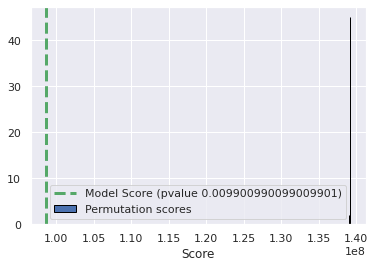

In [161]:
train, test = split_data(df_ntrain)
model = permutation_test(train,test, 'homepage')
model = permutation_test(train, test, 'crew_rgp')
model = permutation_test(train, test, 'cast_power')

Write your answer here

# Part 9 - Predicton

## General Preprocessing 

In [362]:
#Dropping unnecessary columns


def update_total_revenue():
  global df_genres, df_lang, df_pd_cmp, df_pd_cnt, df_kw, df_actors, df_crew, df_ntrain
  df_pd_cmp['Revenue'] = 0
  df_genres['Revenue'] = 0
  df_pd_cnt['Revenue'] = 0
  df_lang['Revenue'] = 0
  df_kw['Revenue'] = 0
  df_actors['Revenue'] = 0
  df_crew['Revenue'] = 0

  df_pd_cmp['Total'] = 0
  df_genres['Total'] = 0
  df_pd_cnt['Total'] = 0
  df_lang['Total'] = 0
  df_kw['Total'] = 0
  df_actors['Total'] = 0
  df_crew['Total'] = 0

  df_ntrain.apply(lambda x: get_total_rev(x['genres'], x['revenue'], df_genres), axis= 1)
  print('g')
  df_ntrain.apply(lambda x: get_total_rev(x['spoken_languages'], x['revenue'], df_lang), axis= 1)
  print('l')
  df_ntrain.apply(lambda x: get_total_rev(x['production_companies'], x['revenue'], df_pd_cmp), axis= 1)
  print('com')
  df_ntrain.apply(lambda x: get_total_rev(x['production_countries'], x['revenue'], df_pd_cnt), axis= 1)
  print('cnt')
  df_ntrain.apply(lambda x: get_total_rev(x['Keywords'], x['revenue'], df_kw), axis= 1)
  print('kw')
  df_ntrain.apply(lambda x: get_total_rev_cast(x['cast'], x['revenue'], df_actors), axis= 1)
  print("actors")
  df_ntrain.apply(lambda x: get_total_rev_crew(x['crew'], x['revenue'], df_crew), axis= 1)
  print("crew")


  df_genres['Avg_revenue'] = df_genres['Revenue']/df_genres['Total']
  df_lang['Avg_revenue'] = df_lang['Revenue']/df_lang['Total']
  df_pd_cmp['Avg_revenue'] = df_pd_cmp['Revenue']/df_pd_cmp['Total']
  df_pd_cnt['Avg_revenue'] = df_pd_cnt['Revenue']/df_pd_cnt['Total']
  df_kw['Avg_revenue'] = df_kw['Revenue']/df_kw['Total']
  df_actors['Avg_revenue'] = df_actors['Revenue']/df_actors['Total']
  df_crew['Avg_revenue'] = df_crew['Revenue']/df_crew['Total']
  
  df_genres.fillna(0, inplace=True)
  df_pd_cmp.fillna(0, inplace=True)
  df_pd_cnt.fillna(0, inplace=True)
  df_kw.fillna(0, inplace=True)
  df_lang.fillna(0, inplace=True)
  df_actors.fillna(0, inplace=True)
  df_crew.fillna(0, inplace=True)

def update_rgp(df):
  global genres_rgp, lang_rgp, pd_cmp_rgp, pd_cnt_rgp, kw_rgp, actor_rgp, crew_rgp
  id = df_genres.id.to_list()
  rev = df_genres.Avg_revenue.to_list()
  genres_rgp = {id[i]:rev[i] for i in range(len(id))}

  id = df_lang.id.to_list()
  rev = df_lang.Avg_revenue.to_list()
  lang_rgp = {id[i]:rev[i] for i in range(len(id))}

  id = df_pd_cmp.id.to_list()
  rev = df_pd_cmp.Avg_revenue.to_list()
  pd_cmp_rgp = {id[i]:rev[i] for i in range(len(id))}

  id = df_pd_cnt.id.to_list()
  rev = df_pd_cnt.Avg_revenue.to_list()
  pd_cnt_rgp = {id[i]:rev[i] for i in range(len(id))}

  id = df_kw.id.to_list()
  rev = df_kw.Avg_revenue.to_list()
  kw_rgp = {id[i]:rev[i] for i in range(len(id))}

  id = df_actors.id.to_list()
  rev = df_actors.Avg_revenue.to_list()
  actor_rgp = {id[i]:rev[i] for i in range(len(id))}

  id = df_crew.id.to_list()
  rev = df_crew.Avg_revenue.to_list()
  crew_rgp = {id[i]:rev[i] for i in range(len(id))}



  df['genre_rgp'] = df['genres'].apply(lambda x: get_rgp(x, genres_rgp))
  df['sp_lang_rgp'] = df['spoken_languages'].apply(lambda x: get_rgp(x, lang_rgp))
  df['pd_cmp_rgp'] =  df['production_companies'].apply(lambda x: get_rgp(x, pd_cmp_rgp))
  df['pd_cnt_rgp'] = df['production_countries'].apply(lambda x: get_rgp(x, pd_cnt_rgp))
  df['keywords_rgp'] = df ['Keywords'].apply(lambda x: get_rgp(x, kw_rgp))
  df['cast_power'] =  df['cast'].apply(lambda x:cast_power(x, actor_freq))
  df['crew_rgp'] =  df['crew'].apply(lambda x:crew_power(x, crew_freq))

  return df




def log_transformation(df_final):
  df_final['budget'] = df_final['budget'].apply(lambda x: np.log(x))
  df_final['crew_rgp'] = df_final['crew_rgp'].apply(lambda x: np.log(x+1))
  df_final ['cast_power'] = df_final['cast_power'].apply(lambda x: np.log(x+1))
  df_final ['genre_rgp'] = df_final['genre_rgp'].apply(lambda x: np.log(x+1))
  df_final ['pd_cmp_rgp'] = df_final['pd_cmp_rgp'].apply(lambda x: np.log(x+1))
  df_final ['pd_cnt_rgp'] = df_final['pd_cnt_rgp'].apply(lambda x: np.log(x+1))
  df_final ['keywords_rgp'] = df_final['keywords_rgp'].apply(lambda x: np.log(x+1))
  df_final['sp_lang_rgp'] = df_final['sp_lang_rgp'].apply(lambda x: np.log(x+1))
  return df_final



In [587]:
%%time
update_total_revenue()


df_final.sample(1) 

g
l
com
cnt
kw
actors
crew
CPU times: user 4min 26s, sys: 9.9 s, total: 4min 36s
Wall time: 4min 38s


In [618]:
df_ntrain.columns

Index(['id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'production_companies', 'production_countries',
       'release_date', 'runtime', 'spoken_languages', 'tagline', 'title',
       'Keywords', 'cast', 'crew', 'revenue', 'Month', 'Day', 'Year',
       'cast_power', 'imdb_rating', 'votes', 'metascore',
       'month_revenue_factor', 'drc_factor', 'comp_factor',
       'country_popularity', 'company_popularity', 'genre_popularity',
       'lang_popularity', 'kw_popularity'],
      dtype='object')

In [619]:
columns = ['belongs_to_collection', 'budget', 'homepage', 'popularity', 'runtime', 'revenue', 'cast_power', 'imdb_rating', 'votes', 'metascore', 'genre_rgp', 'sp_lang_rgp','pd_cmp_rgp','pd_cnt_rgp', 'keywords_rgp', 'crew_rgp', 'month_revenue_factor', 'drc_factor', 'country_popularity', 'company_popularity', 'genre_popularity', 'lang_popularity', 'kw_popularity']
df_ntrain['metascore'] = df_ntrain['metascore'].fillna(5)
df_ntrain.loc[df_ntrain['metascore']<=5, 'metascore'] =5
df_final = df_ntrain.copy()
df_final = update_rgp(df_final)
df_final = df_final[columns]
df_final = log_transformation(df_final)
df_final['revenue'] = df_final['revenue'].apply(lambda x: np.log(x))
df_final.sample(1)

,belongs_to_collection,budget,homepage,popularity,runtime,revenue,cast_power,imdb_rating,votes,metascore,genre_rgp,sp_lang_rgp,pd_cmp_rgp,pd_cnt_rgp,keywords_rgp,crew_rgp,month_revenue_factor,drc_factor,country_popularity,company_popularity,genre_popularity,lang_popularity,kw_popularity
2836,0,15.201805,0,5.350658,99.0,9.129239,7.67821,6.1,16587,49.0,18.96488,18.090188,14.820411,18.164206,19.446948,3.207451,0.21298,0.091988,1,0,2,1,0


## Baseline Model 1

### Feature Selection and Engineering

### Training Model

In [246]:
def build_baseline_model(data):
  from sklearn.model_selection import train_test_split 
  train, test = train_test_split(data, test_size=0.2, random_state=1) 

  X_train = train.drop(['revenue'], axis=1)
  y_train = train.revenue

  X_test = test.drop(['revenue'], axis=1)
  y_test = test.revenue

  reg = linear_model.LinearRegression() 
  
  model = reg.fit(X_train, y_train) 
  print('Coefficients: \n', reg.coef_) 
  print('Intercept: \n', reg.intercept_) 
  print(y_test.shape)
  print('Variance score: {}'.format(reg.score(X_test, y_test))) 

  y_pred = model.predict(X_test)
  rmsle = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
  print(rmsle)
  return model


In [205]:
print(columns)

['belongs_to_collection', 'budget', 'homepage', 'popularity', 'runtime', 'revenue', 'cast_power', 'imdb_rating', 'votes', 'metascore', 'genre_rgp', 'sp_lang_rgp', 'pd_cmp_rgp', 'pd_cnt_rgp', 'keywords_rgp', 'crew_rgp', 'month_revenue_factor', 'drc_factor', 'comp_factor']


In [ ]:
curr_col = ['belongs_to_collection', 'budget', 'homepage', 'popularity', 'revenue','runtime', 'cast_power', 'imdb_rating', 'votes', 'metascore', 'genre_rgp', 'sp_lang_rgp','pd_cmp_rgp','pd_cnt_rgp', 'keywords_rgp', 'crew_rgp', 'month_revenue_factor',  'country_popularity', 'company_popularity', 'genre_popularity', 'lang_popularity', 'kw_popularity']
print(df.shape)
df = df_final[curr_col]
b_model1 = build_baseline_model(df)


## Baseline Model 2

In [384]:
df_final.corr()

,belongs_to_collection,budget,homepage,popularity,runtime,revenue,cast_power,imdb_rating,votes,metascore,genre_rgp,sp_lang_rgp,pd_cmp_rgp,pd_cnt_rgp,keywords_rgp,crew_rgp,month_revenue_factor,drc_factor,comp_factor
belongs_to_collection,1.000000,0.122502,0.060001,0.155896,-0.036117,0.260223,0.099920,-0.080439,0.214592,-0.107634,0.220061,0.056732,0.135613,0.050072,0.116636,0.152661,0.081134,-0.059950,0.063926
budget,0.122502,1.000000,0.158222,0.239190,0.168782,0.459910,0.464698,-0.073736,0.305855,-0.113702,0.259714,0.168091,0.392909,0.244138,0.206028,0.378497,0.121023,-0.003014,-0.069157
homepage,0.060001,0.158222,1.000000,0.164797,0.041772,0.142493,0.079460,0.073442,0.265605,0.054119,0.023931,0.071492,0.099349,0.080427,0.121218,0.071742,0.003945,-0.112423,-0.226372
popularity,0.155896,0.239190,0.164797,1.000000,0.134027,0.291634,0.239608,0.154367,0.443858,0.114483,0.146934,0.092859,0.244602,0.145631,0.191151,0.233261,0.063679,-0.071553,-0.028748
runtime,-0.036117,0.168782,0.041772,0.134027,1.000000,0.213724,0.145453,0.338349,0.246893,0.266471,0.025630,0.046613,0.126629,0.024395,0.119330,0.222028,0.118027,-0.052511,0.014568
revenue,0.260223,0.459910,0.142493,0.291634,0.213724,1.000000,0.528230,0.092423,0.401967,0.030848,0.297577,0.218509,0.637934,0.264292,0.361143,0.578374,0.141958,0.030603,0.053148
cast_power,0.099920,0.464698,0.079460,0.239608,0.145453,0.528230,1.000000,-0.065530,0.300231,-0.064515,0.334328,0.248885,0.513275,0.421054,0.292763,0.455859,0.062153,0.088964,0.022197
imdb_rating,-0.080439,-0.073736,0.073442,0.154367,0.338349,0.092423,-0.065530,1.000000,0.371799,0.678924,-0.142665,0.038186,0.045437,-0.023966,0.172435,0.138640,0.067478,-0.128152,0.032557
votes,0.214592,0.305855,0.265605,0.443858,0.246893,0.401967,0.300231,0.371799,1.000000,0.269105,0.152979,0.123414,0.279434,0.148878,0.242475,0.362455,0.110046,-0.094442,-0.031076
metascore,-0.107634,-0.113702,0.054119,0.114483,0.266471,0.030848,-0.064515,0.678924,0.269105,1.000000,-0.111754,0.043780,-0.017608,-0.057298,0.084105,0.096015,0.068152,-0.130227,0.035062


In [405]:
df_final.votes.max()

2278845

In [442]:
df.metascore.min()

0.0

In [429]:
curr_col = ['belongs_to_collection', 'budget', 'homepage', 'revenue', 'cast_power', 'votes','metascore' ,'genre_rgp','pd_cmp_rgp', 'keywords_rgp', 'crew_rgp', 'month_revenue_factor']
print(df.shape)
df = df_final[curr_col]
b_model2 = build_baseline_model(df)

(3000, 11)
Coefficients: 
 [9.17433156e-01 2.03540312e-01 1.43351334e-01 1.28217245e-01
 1.70723182e-06 8.03098543e-04 8.88799216e-02 3.17822048e-01
 2.13102509e-02 1.66434261e-01 5.96614230e-01]
Intercept: 
 1.687035370553895
(600,)
Variance score: 0.5113056127618183
2.139080524014383


##Advanced Models

In [ ]:
def build_advanced_model_rf(data):
  train, test = train_test_split(data, test_size=0.2, random_state=1) 

  X_train = train.drop(['revenue'], axis=1)
  y_train = train.revenue

  X_test = test.drop(['revenue'], axis=1)
  y_test = test.revenue

  from sklearn.ensemble import RandomForestRegressor 
  reg = RandomForestRegressor(n_estimators = 100, random_state = 0) 
  model = reg.fit(X_train, y_train)
  print('Variance score: {}'.format(reg.score(X_test, y_test))) 

  y_pred = model.predict(X_test)
  rmsle = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
  print(rmsle)
  return model


In [ ]:
curr_col = ['belongs_to_collection', 'budget', 'homepage', 'popularity', 'revenue', 'runtime', 'cast_power', 'imdb_rating', 'votes', 'metascore', 'genre_rgp', 'sp_lang_rgp','pd_cmp_rgp','pd_cnt_rgp', 'keywords_rgp', 'crew_rgp', 'month_revenue_factor', 'drc_factor', 'country_popularity', 'company_popularity', 'genre_popularity', 'lang_popularity', 'kw_popularity']
print(df.shape)
df = df_final[curr_col]
adv_model_rf = build_advanced_model_rf(df)

(3000, 23)
Variance score: 0.6871095669424154
1.711609152752066


In [688]:
def build_advanced_model_gb(data):
  train, test = train_test_split(data, test_size=0.2, random_state=1) 

  X_train = train.drop(['revenue'], axis=1)
  y_train = train.revenue

  X_test = test.drop(['revenue'], axis=1)
  y_test = test.revenue

  from sklearn.ensemble import GradientBoostingRegressor 
  reg = GradientBoostingRegressor(n_estimators = 100, random_state = 0) 
  model = reg.fit(X_train, y_train)
  print('Variance score: {}'.format(reg.score(X_test, y_test))) 

  y_pred = model.predict(X_test)
  rmsle = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
  print(rmsle)
  return model


In [732]:
curr_col = ['belongs_to_collection', 'budget', 'homepage', 'popularity', 'revenue', 'runtime', 'cast_power', 'imdb_rating', 'votes', 'metascore', 'genre_rgp', 'sp_lang_rgp','pd_cmp_rgp','pd_cnt_rgp', 'keywords_rgp', 'crew_rgp', 'month_revenue_factor', 'drc_factor', 'country_popularity', 'company_popularity', 'genre_popularity', 'lang_popularity', 'kw_popularity']
print(df.shape)
df = df_final[curr_col]
adv_model_gb = build_advanced_model_rf(df)

(3000, 22)
Variance score: 0.6871095669424154
1.711609152752066


In [669]:
def build_advanced_model_nn(data):
  train, test = train_test_split(data, test_size=0.2, random_state=1) 

  X_train = train.drop(['revenue'], axis=1)
  y_train = train.revenue

  X_test = test.drop(['revenue'], axis=1)
  y_test = test.revenue

  from sklearn.neural_network import MLPRegressor
  reg = MLPRegressor(hidden_layer_sizes=(70,30), activation='logistic', max_iter=1000) 
  model = reg.fit(X_train, y_train)
  print(len(model.loss_curve_),model.loss_curve_)
  print('Variance score: {}'.format(reg.score(X_test, y_test))) 

  y_pred = model.predict(X_test)
  rmsle = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
  print(rmsle)
  return model


In [ ]:
df_ntrain.corr()

In [670]:
curr_col = ['belongs_to_collection', 'budget', 'homepage', 'popularity', 'runtime', 'revenue', 'cast_power', 'imdb_rating', 'votes', 'metascore', 'genre_rgp', 'sp_lang_rgp','pd_cmp_rgp','pd_cnt_rgp', 'keywords_rgp', 'crew_rgp', 'month_revenue_factor', 'country_popularity', 'company_popularity', 'genre_popularity', 'lang_popularity', 'kw_popularity']
#curr_col = ['belongs_to_collection', 'budget', 'homepage', 'popularity', 'runtime', 'revenue', 'cast_power', 'imdb_rating', 'votes', 'metascore', 'genre_rgp', 'sp_lang_rgp','pd_cmp_rgp' 'crew_rgp', 'month_revenue_factor',  'country_popularity', 'company_popularity', 'genre_popularity', 'lang_popularity', 'kw_popularity']
print(df.shape)
df = df_final[curr_col]
adv_model_nn = build_advanced_model_nn(df)

(3000, 20)
166 [128.7086223438021, 119.27913819197522, 110.3676221619615, 103.00251675198224, 97.08529563495941, 92.13800984789903, 88.13570550962478, 84.50212522100583, 81.05739138746328, 77.65396672272641, 74.40750301887547, 71.14459250469866, 68.07155491955213, 65.21364152196792, 62.514556613934865, 59.916544994898224, 57.45601209827851, 55.128282108893785, 52.94043601668351, 50.829584862045955, 48.811421884199305, 46.86989973707074, 45.0063104817642, 43.19352387390568, 41.42451957320923, 39.66602962817876, 37.91400741084596, 36.20837369423476, 34.561663436482824, 33.00170734504297, 31.514931188249964, 30.11280290963048, 28.766040929755217, 27.48315396007662, 26.270808411109023, 25.10560837753284, 24.001696601183053, 22.94516571142085, 21.943907881902074, 20.984317163399933, 20.07375220854427, 19.202355704437245, 18.381326525959604, 17.586380267232705, 16.84369124813658, 16.130443888703986, 15.453738738449387, 14.810655445662572, 14.198333060215413, 13.619231427198798, 13.0688993902

### Testing on Kaggle Data

In [433]:
df_ntest.sample(1)
df_ntest['Month'] = df_ntest['release_date'].apply(lambda date: date.strftime("%B") )
df_ntest['Day'] = df_ntest['release_date'].apply(lambda date: date.strftime("%A") )
df_ntest['Year'] = df_ntest['release_date'].apply(lambda date: date.strftime("%Y") )
df_ntest.sample(1)

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,spoken_languages,tagline,title,Keywords,cast,crew,imdb_rating,votes,metascore,Month,Day,Year
4070,7071,1,80000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",1,tt0290002,en,Meet the Fockers,"Hard-to-crack ex-CIA man, Jack Byrnes and his ...",11.876386,"[{'name': 'DreamWorks SKG', 'id': 27}, {'name'...","[{'name': 'United States of America', 'id': 'U...",2004-12-22,115.0,"[{'name': 'English', 'id': 'en'}]",Misery loves family.,Meet the Fockers,"[{'id': 591, 'name': 'cia'}, {'id': 970, 'name...","[{'cast_id': 22, 'character': 'Gaylord 'Greg' ...","[{'credit_id': '52fe426bc3a36847f801d309', 'de...",6.3,249128,41.0,December,Wednesday,2004


In [ ]:
df_ntest = pd.merge(df_ntest, month_revenue)
df_ntest = df_ntest.drop(['m_revenue'], axis=1)

df_ntest = pd.merge(df_ntest, day_release, sort=False)
df_ntest = df_ntest.drop(['Release Count'], axis=1)

df = df_ntest.copy()
def count_comp(x):
  be = x - datetime.timedelta(days=13)
  af = x + datetime.timedelta(days=13)
  n = len(df.loc[(df['release_date']>=be) & (df['release_date']<=af)])-1
  return n
  
df['comp_movies'] = df['release_date'].apply(count_comp)
df['comp_factor'] = 1/ df['comp_movies']
df_ntest['comp_factor'] = df['comp_factor']
df_ntest = df_ntest.sort_values(by='id')
df_ntest

In [ ]:
columns = ['belongs_to_collection', 'budget', 'homepage', 'popularity', 'runtime', 'cast_power', 'imdb_rating', 'votes', 'metascore', 'genre_rgp', 'sp_lang_rgp','pd_cmp_rgp','pd_cnt_rgp', 'keywords_rgp', 'crew_rgp', 'month_revenue_factor', 'drc_factor', 'country_popularity', 'company_popularity', 'genre_popularity', 'lang_popularity', 'kw_popularity']
def process_test_data(df):
  global columns
  df = update_rgp(df)
  df = df[columns]
  df = log_transformation(df)
  return df
df_ntest['metascore'] = df_ntest.metascore.fillna(5)
df_ntest.loc[df_ntest['metascore']<=5, 'metascore'] =5
df_test_final = df_ntest.copy()
df_test_final =process_test_data(df_test_final)
df_test_final.sample(1)

In [445]:
df_ntest.metascore.min()

5.0

### Testing Baseline Model 1

In [324]:
curr_col = ['belongs_to_collection', 'budget', 'homepage', 'popularity', 'runtime']
df_test_curr = df_test_final[curr_col]
y_pred = b_model1.predict(df_test_curr)
y_pred = np.exp(y_pred)

In [325]:
submission = df_ntest[['id']]
submission['revenue'] = y_pred
submission.to_csv(r'/content/drive/My Drive/Colab Notebooks/HW3 Data/submission_b_model_1.csv', index = False, header=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Testing Baseline Model 2

In [388]:
curr_col = ['belongs_to_collection', 'budget', 'homepage', 'cast_power', 'votes', 'genre_rgp','pd_cmp_rgp', 'keywords_rgp', 'crew_rgp', 'month_revenue_factor']
df_test_curr = df_test_final[curr_col]
y_pred = b_model2.predict(df_test_curr)
y_pred = np.exp(y_pred)

In [389]:
submission = df_ntest[['id']]
submission['revenue'] = y_pred
submission.to_csv(r'/content/drive/My Drive/Colab Notebooks/HW3 Data/submission_b_model_2.csv', index = False, header=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Testing Advanced Model 1

In [686]:
curr_col =  ['belongs_to_collection', 'budget', 'homepage', 'popularity', 'runtime', 'cast_power', 'imdb_rating', 'votes', 'metascore', 'genre_rgp', 'sp_lang_rgp','pd_cmp_rgp','pd_cnt_rgp', 'keywords_rgp', 'crew_rgp', 'month_revenue_factor', 'drc_factor', 'country_popularity', 'company_popularity', 'genre_popularity', 'lang_popularity', 'kw_popularity']
df_test_curr = df_test_final[curr_col]
y_pred = adv_model_rf.predict(df_test_curr)
y_pred = np.exp(y_pred)

In [687]:
submission = df_ntest[['id']]
submission['revenue'] = y_pred
submission.to_csv(r'/content/drive/My Drive/Colab Notebooks/HW3 Data/submission_adv_model_1.csv', index = False, header=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [734]:
curr_col =  ['belongs_to_collection', 'budget', 'homepage', 'popularity',  'runtime', 'cast_power', 'imdb_rating', 'votes', 'metascore', 'genre_rgp', 'sp_lang_rgp','pd_cmp_rgp','pd_cnt_rgp', 'keywords_rgp', 'crew_rgp', 'month_revenue_factor', 'drc_factor', 'country_popularity', 'company_popularity', 'genre_popularity', 'lang_popularity', 'kw_popularity']
df_test_curr = df_test_final[curr_col]
y_pred = adv_model_gb.predict(df_test_curr)
y_pred = np.exp(y_pred)

In [735]:
submission = df_ntest[['id']]
submission['revenue'] = y_pred
submission.to_csv(r'/content/drive/My Drive/Colab Notebooks/HW3 Data/submission_adv_model_3.csv', index = False, header=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


### Testing Advanced Model 2

In [673]:
curr_col =  ['belongs_to_collection', 'budget', 'homepage', 'popularity', 'runtime',  'cast_power', 'imdb_rating', 'votes', 'metascore', 'genre_rgp', 'sp_lang_rgp','pd_cmp_rgp','pd_cnt_rgp', 'keywords_rgp', 'crew_rgp', 'month_revenue_factor', 'country_popularity', 'company_popularity',  'lang_popularity' ]
df_test_curr = df_test_final[curr_col]
y_pred = adv_model_nn.predict(df_test_curr)
y_pred = np.exp(y_pred)

In [674]:
submission = df_ntest[['id']]
submission['revenue'] = y_pred
submission.to_csv(r'/content/drive/My Drive/Colab Notebooks/HW3 Data/submission_adv_model_2.csv', index = False, header=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Write your answer here

# Part 10 - Final Result

Report your highest score. Include a snapshot of your best score after submission as confirmation. Be sure to provide a link to your Kaggle profile. Make sure your profile includes your face and affiliation with SBU.

Kaggle Link: FILL HERE

Highest Score: FILL HERE

Number of entries: FILL HERE

INCLUDE IMAGE OF YOUR HIGHEST SCORE